In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

AA_data= pd.read_csv('updated_labels_with_text.csv')
AA_data = AA_data.loc[:, ~AA_data.columns.str.contains('^Unnamed')]
AA_data= AA_data[AA_data.majority_label.isin(['N','F','A'])]
AA_data.majority_label.value_counts(), len(AA_data)

(N    259
 A    115
 F     26
 Name: majority_label, dtype: int64,
 400)

In [6]:
full_data_update= AA_data.copy()

In [12]:
# Define a function to determine the majority label
def majority_label(row):
    labels = [row['annotator_1'], row['annotator_2'], row['annotator_3']]
    if labels.count('N') >= 2:
        return 'N'
    elif labels.count('A') >= 2:
        return 'A'
    elif labels.count('F') >= 2:
        return 'F'
    else:
        return 'fill'

# Apply the function to each row
full_data_update['majority_label'] = full_data_update.apply(majority_label, axis=1)
full_data_update['majority_label'].value_counts()

N       264
A       109
F        25
fill      2
Name: majority_label, dtype: int64

# Kappa Values

In [15]:
data_kappa= full_data_update[['annotator_1','annotator_2', 'annotator_3']] 
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa
from statsmodels.stats import inter_rater as irr

print(cohen_kappa_score(data_kappa['annotator_1'], data_kappa['annotator_2']))
print(cohen_kappa_score(data_kappa['annotator_1'], data_kappa['annotator_3']))
print(cohen_kappa_score(data_kappa['annotator_2'], data_kappa['annotator_3']))
print('\n')
agg= irr.aggregate_raters(data_kappa)
print(irr.fleiss_kappa(agg[0], method= 'fleiss'))

0.6555952722623737
0.6613367522194538
0.5347249440532031


0.616412390328433


# LLMs & Prompts

In [ ]:
import openai
openai.api_key = 'XXXXXXXXX'
from openai import OpenAI
client = OpenAI(api_key= openai.api_key)
test_df['Final_label'] = test_df['majority_label'].map({'F': 'Favor', 'A': 'Against', 'N': 'Neutral'})
full_data_update['Final_label'] = full_data_update['majority_label'].map({'F': 'Favor', 'A': 'Against', 'N': 'Neutral'})

# Fine Grained

In [7]:
data_p1= pd.read_csv('annotation_part1-2024-06-24.csv')
data_p2= pd.read_csv('annotation_part2-2024-06-24.csv')
data_p3= pd.read_csv('annotation_part3-2024-06-24.csv')
data_FG= pd.concat([data_p1, data_p2, data_p3])
len(data_FG)

400

In [8]:
# Merge DataFrame B into DataFrame A based on the common column
data_merged = pd.merge(full_data_update, data_FG[['File', 'Final_Label']], on='File', how='left')
data_merged['Final_Label']= data_merged['Final_Label'].replace('Irrelevant', 'No Stance')

# Prompts combined:

In [16]:
template_copy= ''' Instruction: You are an expert linguist, specialized in stance detection. Complete the two tasks below with respect to the instructions, definitions and examples provided to you. 

Task 1: This is a stance classification task. Read the following statement and determine its stance towards Affirmative Action. Respond with only one of these labels: 'Favor', 'Against', 'Neutral'.  

 
Task 2: based on the label you selected in Task 1, determine the fine-grained stance towards Affirmative Action. Respond with one of these 9 labels: 'Strong Favor', 'Weak Favor', 'Strong Against', 'Weak Against', 'Question Favor', 'Question Against', 'Question', 'Skeptical', or 'No Stance' following the condition below:

Condition:

If the label for Task 1 is 'Favor', the correct label for Task 2 will be either 'Strong Favor', 'Weak Favor', or 'Question Favor'.
If the label for Task 2 is 'Against', the correct label for Task 2 will be either 'Strong Against', 'Weak Against', or 'Question Against'.
If the label for Task 3 is 'Neutral', the correct label for Task 2 will be either 'Question', 'Skeptical', or 'No Stance'.

 

Definitions: 

Affirmative Action Definition: Affirmative Action (AA) represents a set of policies and practices aimed at addressing historical and ongoing inequalities in employment, education, and other sectors by providing opportunities to historically marginalized groups. These measures are designed to promote diversity and rectify socio-economic disparities caused by past discrimination. 

 

Stance Definition: Stance is the expression of the speaker’s standpoint and judgment toward a given target, usually a controversial cultural, social, or political topic such as affirmative action.  The definition of stance labels:  

Favor: The speaker supports and defends affirmative action policies, discussing their necessity, justification, benefits and positive impacts. This support could be stronger or weaker (different degrees of support for AA), explicit or implicit. Favor stance can show itself in a question as well, where the statement includes a question but also implies support for AA.  

Against: The speaker opposes and criticizes affirmative action policies, discussing their discrimination, harm, problems and negative impacts. This opposition could be stronger or weaker (different degrees of opposition to AA), explicit or implicit. Against stance can show itself in a question as well, where the statement includes a question but also implies opposition to AA.  

Neutral: The speaker does not take a stance in support or opposition to affirmative action and remains neutral. This includes when speaker has a neutral opinion about AA, or is simply asking a question about the issue without implicit support or opposition to AA. This label is also applicable when affirmative action is not the main topic discussed in the statement. If AA is briefly mentioned in the statement but is not the main topic, use this label. 

 

Definition of fine-grained Stance: Stance is the expression of the speaker’s standpoint and judgment toward a given target, usually a controversial cultural, social, or political topic such as affirmative action. Fine-grained stance is the more detailed version of stance, where we break down each main category of stance (Favor, Against, Neutral) into different sub-categories.


The definition of fine-grained stance labels:   

Strong Favor: The speaker strongly supports and defends affirmative action policies, discussing their necessity and benefits, often using a passionate language in supporting AA.   

Weak Favor: The speaker supports affirmative action but with less intensity and certainty, maybe even critiquing some aspects of AA but showing support for it overall.   

Strong Against: The speaker strongly opposes affirmative action policies, their harm and unfairness and discrimination, often using emotional language against AA.   

Weak Against: The speaker opposes affirmative action but with less intensity and certainty, maybe even supporting some aspects of AA but showing opposition to it overall.   

Question Favor: The speaker asks a question or seeks opinions of others about AA but also carries an implicit support for affirmative action.   

Question Against: The speaker asks a question or seeks opinions of others about AA but also carries an implicit opposition to affirmative action.   

Question: The speaker is asking a relevant question or seeking opinions of others about affirmative action without showing an implicit personal stance.   

Skeptical: The speaker raises doubt or skepticism about the relevance, effectiveness or justification of affirmative action, or suggesting alternatives to change the current version of AA.   

No Stance: The speaker is completely neutral toward affirmative action and does not show any type or degree of support or opposition to affirmative action. The speakers remains totally neutral and unbiased. Also use this label if you think the text is irrelevant to affirmative action!

 

Examples: 

Example for different stance labels (Task 1):   


Post: Affirmative Action is just racism disguised as inclusivity. I would be fine with it if it was based on income. But it isnt. My black classmates have a much better chance of getting into a school with the same test scores as me(I'm white). My friends that are black grew up in the same town as me, had the same amount of priviledge, took the same tests as me, yet the fact that they have more melanin in their skin gives them advantage over me. I can only imagine how bad it is for asain kids.  

Label: Against 

  

Post: As a caucasian, is it to my advantage or disadvantage to fill out an Affirmative Action form for a new job? Why? I usually don't fill these things out because I don't see how it could be beneficial to me. 

Label: Neutral 

  

Post: Affirmative action is a valuable tool for increasing campus diversity at colleges and universities and benefits the entire student body. CMV! **A more diverse student body provides a richer cultural, social, and intellectual atmosphere than would be possible by admitting simply on the basis of conventional admission metrics such as academic achievement and standardized testing. All students who do attend the university benefit from this diversity more than they would from marginally more students with slightly higher grades and test scores.** 

My argument is from the perspective of providing the best possible experience for students at the school. For the sake of this viewpoint. 

Label: Favor 

  

Post: It's a luxury belief to think that "positive" discrimination will alleviate America's current problems. Call me a cynic, but I think it's going to make things much worse. 

These Racial preference policies have a nagging tendency to be put in place as a stopgap, only to become status quo. I know many people that believe that Affirmative Action is meant to be put in place indefinitely and have no idea the efficacy of the actual policy. They take disparities today to double down on AA and say it needs to be in the workplace and elsewhere. 

I would love for people to bring up adversity more. I understand the argument that if you are an outlier growing up in adverse conditions, that it speaks volumes to your character and that is indicative of future success and is a great role model for others to look up towards. 

Label: Neutral 

  

Post: Affirmative Action in college admissions - I'm all for it.  If you disagree, please explain to me why I'm crazy.   I don't see considering race in college admissions as any different from admitting someone on the basis of their abilities in something like sports, art or music.  Part of the college experience is encountering and interacting with diverse cultural/ethnic/racial backgrounds, and if it takes affirmative action to build a diverse student body, I'm all for it.  I think every student will benefit (not just the favored minorities).  

A lot of people think I'm wrong.  I like to think of myself as a fair-minded person. So affirmative action haters, here's your chance to persuade me otherwise.   

Label: Favor 

  

Post: Has affirmative action helped or hurt you in the workplace? I've heard some say that it's beneficial from the standpoint that companies who support affirmative action will be more likely to hire minorities that are perfectly capable of the job yet may be overlooked during the hiring process. 

As an African American I feel that affirmative action actually does more harm than good due to a promotion possibly being a result of your ethnicity and not your ability. What say you, Reddit? 

Label: Against 

  

Post: Supreme court will decide next whether affirmative action should be continued or not 

Label: Neutral 

  

Post: Affirmative Action hurts blacks/Latinos more than Asian Think about it, everyone expects Blacks/Latino  in ivy college to be there for one reason: diversity. These low expectations will mean most jobs wont hire them since they ate percieved as unqualified. 

Label: Against 

  

Post: We are currently researching affirmative action, specifically in colleges, and it got me into thinking about creating an experiment to detect what actually makes a person less intelligent than another, and how that experiment would affect the people involved. 

Label: Neutral 

  

Post: Why do these people think that those of a different race can't get into college on their own or into a good job on their own. Affirmative Action seems to be nothing more than a way to be racist in hopes of helping people who don't need the help to begin with. Please, explain to me how affirmative action is okay.  

Label: Against 

  

Post: The best way to make women equal to men is to simply treat them as equals Too many women get preferable treatments due to affirmative action when getting a job/ going to college.\n\nIt may look good on paper to see more women in STEM fields or earning more or less the same as their male counterparts, but the sad reality is that many of these women would not be where they are if it wasn’t for the benefits they get exclusively due to their sex. We need to start treating women as equals if we want them to truly become equals because, if you give them preferable treatments you are effectively saying they are not good enough. It may take long, maybe generations, but I truly believe women and men will play the same roles in intellectual professions (by which I mean not physical labor where men are simply biologically better suited to perform) IF we treat them the same as men. If we don’t, I believe political and executive positions will always be dominated by men as women will not be able to compete in a truly even and merit-based playing field.\n\nFurthermore, it’s a disgrace for women’s achievements to be so easily dismissible even if they are truly earned and not rewarded for being female. If a woman is incredibly successful, her achievements will be much more scrutinized because there is a possibility that she is simply there because of her sex and not because of her abilities. This will always remain an argument until no more affirmative action, or female quotas are in place and it is indisputable that men and women face the same hardships. 

Label: Against 

  

Post: Is class more important than Race in Britain? I am a supporter of Affirmative Action, however in Britain studies show time after time that White people are at a greater disadvantage, especially up north, than they are in America. Would this mean that AA should be placed as a higher priority towards Class as opposed to Race? 

Label: Favor 

  

Post: Affirmative Action is Good Due to prevalent racism in the past, minorities were deprived of the same education and employment opportunities as whites. The government must work to make up for that. America is still a racist society, therefore a federal affirmative action law is necessary. 

Label: Favor 

  

Post: Affirmative action is white liberal guilt run amok, and as racial discrimination, should be plainly illegal. 

Label: Against 

  

Post: In the early 20th century universities used quotas against Jews with policies like "holistic approach", "diversity", and taking top kids from separate districts since Jews were packed into few districts. How is that different than affirmative action today? Quotas are officially illegal, but many universities use unofficial quotas against white and Asian kids (especially Asian kids) by claiming to seek diversity and constantly tweaking admission criteria and emphasis against them, since their GPA and SAT scores were too high and they play too much violin. How is this any different?' 

Label: Against 

  

Post: What are the reasons that people believe we should have affirmative action and why does it target race instead of the poor? THIS IS NOT A POLITICAL DEBATE I just want to know the REASONS people believe Affirmative Action is needed, because it is hard to find an article that addresses the issue that doesn’t change the subject. I’m trying to form my opinion on this controversial topic. 

Label: Neutral 

  

Examples of fine-grained stance (Task 2):   

  

Post: Affirmative Action is just racism disguised as inclusivity. I would be fine with it if it was based on income. But it isnt. My black classmates have a much better chance of getting into a school with the same test scores as me(I'm white). My friends that are black grew up in the same town as me, had the same amount of priviledge, took the same tests as me, yet the fact that they have more melanin in their skin gives them advantage over me. I can only imagine how bad it is for asain kids.  

Label: Strong Against 

  

Post: As a caucasian, is it to my advantage or disadvantage to fill out an Affirmative Action form for a new job? Why? I usually don't fill these things out because I don't see how it could be beneficial to me. 

Label: Question 

  

Post: Affirmative action is a valuable tool for increasing campus diversity at colleges and universities and benefits the entire student body. CMV! **A more diverse student body provides a richer cultural, social, and intellectual atmosphere than would be possible by admitting simply on the basis of conventional admission metrics such as academic achievement and standardized testing. All students who do attend the university benefit from this diversity more than they would from marginally more students with slightly higher grades and test scores.** 

My argument is from the perspective of providing the best possible experience for students at the school. For the sake of this viewpoint. 

Label: Strong Favor 

  

Post: It's a luxury belief to think that "positive" discrimination will alleviate America's current problems. Call me a cynic, but I think it's going to make things much worse. 

These Racial preference policies have a nagging tendency to be put in place as a stopgap, only to become status quo. I know many people that believe that Affirmative Action is meant to be put in place indefinitely and have no idea the efficacy of the actual policy. They take disparities today to double down on AA and say it needs to be in the workplace and elsewhere. 

I would love for people to bring up adversity more. I understand the argument that if you are an outlier growing up in adverse conditions, that it speaks volumes to your character and that is indicative of future success and is a great role model for others to look up towards. 

Label: Skeptical 

  

Post: Affirmative Action in college admissions - I'm all for it.  If you disagree, please explain to me why I'm crazy.   I don't see considering race in college admissions as any different from admitting someone on the basis of their abilities in something like sports, art or music.  Part of the college experience is encountering and interacting with diverse cultural/ethnic/racial backgrounds, and if it takes affirmative action to build a diverse student body, I'm all for it.  I think every student will benefit (not just the favored minorities).  

A lot of people think I'm wrong.  I like to think of myself as a fair-minded person. So affirmative action haters, here's your chance to persuade me otherwise.   

Label: Question Favor



Post: Has affirmative action helped or hurt you in the workplace? I've heard some say that it's beneficial from the standpoint that companies who support affirmative action will be more likely to hire minorities that are perfectly capable of the job yet may be overlooked during the hiring process. 

As an African American I feel that affirmative action actually does more harm than good due to a promotion possibly being a result of your ethnicity and not your ability. What say you, Reddit? 

Label: Question Against 

  

Post: Supreme court will decided next whether affirmative action should be continued or not 

Label: No Stance 

  

Post: Affirmative Action hurts blacks/Latinos more than Asian Think about it, everyone expects Blacks/Latino  in ivy college to be there for one reason: diversity. These low expectations will mean most jobs wont hire them since they ate percieved as unqualified. 

Label: Weak Against 

  

Post: Affirmative action should be based on income level and socioeconomic status, not race, to achieve its goal. America is divided based on class, not race. 

Label: Skeptical 

  

Post: We are currently researching affirmative action, specifically in colleges, and it got me into thinking about creating an experiment to detect what actually makes a person less intelligent than another, and how that experiment would affect the people involved. 

Label: No Stance 

  

Post: Why do these people think that those of a different race can't get into college on their own or into a good job on their own. Affirmative Action seems to be nothing more than a way to be racist in hopes of helping people who don't need the help to begin with. Please, explain to me how affirmative action is okay.  

Label: Question Against 

  

Post: The best way to make women equal to men is to simply treat them as equals Too many women get preferable treatments due to affirmative action when getting a job/ going to college.\n\nIt may look good on paper to see more women in STEM fields or earning more or less the same as their male counterparts, but the sad reality is that many of these women would not be where they are if it wasn’t for the benefits they get exclusively due to their sex. We need to start treating women as equals if we want them to truly become equals because, if you give them preferable treatments you are effectively saying they are not good enough. It may take long, maybe generations, but I truly believe women and men will play the same roles in intellectual professions (by which I mean not physical labor where men are simply biologically better suited to perform) IF we treat them the same as men. If we don’t, I believe political and executive positions will always be dominated by men as women will not be able to compete in a truly even and merit-based playing field.\n\nFurthermore, it’s a disgrace for women’s achievements to be so easily dismissible even if they are truly earned and not rewarded for being female. If a woman is incredibly successful, her achievements will be much more scrutinized because there is a possibility that she is simply there because of her sex and not because of her abilities. This will always remain an argument until no more affirmative action, or female quotas are in place and it is indisputable that men and women face the same hardships. 

Label: Weak Against 

 

Read the following statement and complete Task 1 and Task 2.

Constraint:  

Constraint: Only return the stance using one of the labels allowed for each task (3 labels for Task 1 and 9 labels for Task 2), and no additional text. Also, make sure to separate the correct label for each task by a comma (,) 

Here is the statement:

'''''


# GPT Models

In [421]:
def combined_prompt_gpt3.5(text):
    prompt= template_copy
    
    chat_history = []  # past user and assistant turns for AI memory
    user = [{"role": "user", "content": prompt + '\n' + text + '\n'}]
    chat_completion = client.chat.completions.create(
        messages = chat_history + user, model="gpt-3.5-turbo-0125", temperature= 0.0)
            #print (text, completion.choices[0].message.content)
    return chat_completion.choices[0].message.content

full_answer= data_merged['text'].apply(combined_prompt_gpt3.5).tolist()

In [418]:
stance_general= []
stance_finegrained= []

for i in range(len(full_answer)):
    if ',' not in full_answer[i]:
        stance_general.append(full_answer[i].split('Task 2')[0].replace('Task 1:','').strip())
        stance_finegrained.append(full_answer[i].split('Task 2')[1].replace(':','').strip())
    else:
        stance_general.append(full_answer[i].split(',')[0])
        stance_finegrained.append(full_answer[i].split(',')[1].strip())
        
data_merged['stance_general_gpt3.5']= stance_general
data_merged['stance_finegrained_gpt3.5']= stance_finegrained

In [419]:
accuracy = accuracy_score(data_merged['Final_label'], data_merged['stance_general_gpt3.5'])
precision = precision_score(data_merged['Final_label'], data_merged['stance_general_gpt3.5'], average='weighted', zero_division=0)
recall = recall_score(data_merged['Final_label'], data_merged['stance_general_gpt3.5'], average='weighted', zero_division=0)
f1 = f1_score(data_merged['Final_label'], data_merged['stance_general_gpt3.5'], average='weighted', zero_division=0)

accuracy, precision, recall, f1

(0.6625, 0.7292194224712076, 0.6625, 0.6678785267324716)

In [420]:
accuracy = accuracy_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt3.5'])
precision = precision_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt3.5'], average='weighted', zero_division=0)
recall = recall_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt3.5'], average='weighted', zero_division=0)
f1 = f1_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt3.5'], average='weighted', zero_division=0)

accuracy, precision, recall, f1

(0.4725, 0.5279675995297326, 0.4725, 0.475381040957379)

In [528]:
def combined_prompt_gpt4(text):
    
    openai_clinet = OpenAI(api_key= openai.api_key)
    
    #prompt= prompt_combined_1
    prompt= template_copy


    retries = 2
    model="gpt-4-0125-preview"

    retries = 2
    while retries > 0:
        try:
            completion = openai_clinet.chat.completions.create(
            model= model,
            temperature= 0.0,
            messages=[
                {"role": "user", "content": prompt +'\n' + text}
            ]
                )
            #print (text, completion.choices[0].message.content)
            return(completion.choices[0].message.content)
        except Exception as e:
            if e:
                print(e)
                print('Timeout error, retrying...')
                retries -= 1
                time.sleep(5)
            else:
                raise e
                print('API is not responding, moving on...')
                bad_api = "x"
            return bad_api


full_answer= data_merged['text'].apply(combined_prompt_gpt4).tolist()
full_answer= [i.replace('\n','').strip() for i in full_answer]

In [529]:
stance_general= []
stance_finegrained= []

for i in range(len(full_answer)):
    stance_general.append(full_answer[i].split(',')[0])
    stance_finegrained.append(full_answer[i].split(',')[1].strip())
        
data_merged['stance_general_gpt4']= stance_general
data_merged['stance_finegrained_gpt4']= stance_finegrained

In [530]:
accuracy = accuracy_score(data_merged['Final_label'], data_merged['stance_general_gpt4'])
precision = precision_score(data_merged['Final_label'], data_merged['stance_general_gpt4'], average='weighted', zero_division=0)
recall = recall_score(data_merged['Final_label'], data_merged['stance_general_gpt4'], average='weighted', zero_division=0)
f1 = f1_score(data_merged['Final_label'], data_merged['stance_general_gpt4'], average='weighted', zero_division=0)

accuracy, precision, recall, f1

(0.78, 0.7989277715565509, 0.78, 0.7836817391304348)

In [531]:
accuracy = accuracy_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt4'])
precision = precision_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt4'], average='weighted', zero_division=0)
recall = recall_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt4'], average='weighted', zero_division=0)
f1 = f1_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt4'], average='weighted', zero_division=0)

accuracy, precision, recall, f1

(0.6025, 0.6799758726409718, 0.6025, 0.6170949588505794)

In [430]:
def combined_prompt_gpt4o(text):
    
    openai_clinet = OpenAI(api_key= openai.api_key)
   
    prompt= template_copy


    retries = 2
    model="gpt-4o-2024-05-13"

    retries = 2
    while retries > 0:
        try:
            completion = openai_clinet.chat.completions.create(
            model= model,
            temperature= 0.0,
            messages=[
                {"role": "user", "content": prompt +'\n' + text}
            ]
                )
            #print (text, completion.choices[0].message.content)
            return(completion.choices[0].message.content)
        except Exception as e:
            if e:
                print(e)
                print('Timeout error, retrying...')
                retries -= 1
                time.sleep(5)
            else:
                raise e
                print('API is not responding, moving on...')
                bad_api = "x"
            return bad_api


full_answer= data_merged['text'].apply(combined_prompt_gpt4o).tolist()

In [431]:
stance_general= []
stance_finegrained= []

for i in range(len(a)):
    if ',' not in a[i]:
        stance_general.append(full_answer[i].split('Task 2')[0].replace('Task 1:','').strip())
        stance_finegrained.append(full_answer[i].split('Task 2')[1].replace(':','').strip())
    else:
        stance_general.append(full_answer[i].split(',')[0])
        stance_finegrained.append(full_answer[i].split(',')[1].strip())
        
data_merged['stance_general_gpt4o']= stance_general
data_merged['stance_finegrained_gpt4o']= stance_finegrained

In [432]:
accuracy = accuracy_score(data_merged['Final_label'], data_merged['stance_general_gpt4o'])
precision = precision_score(data_merged['Final_label'], data_merged['stance_general_gpt4o'], average='weighted', zero_division=0)
recall = recall_score(data_merged['Final_label'], data_merged['stance_general_gpt4o'], average='weighted', zero_division=0)
f1 = f1_score(data_merged['Final_label'], data_merged['stance_general_gpt4o'], average='weighted', zero_division=0)

accuracy, precision, recall, f1

(0.685, 0.7968830570400262, 0.685, 0.695431574670117)

In [433]:
accuracy = accuracy_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt4o'])
precision = precision_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt4o'], average='weighted', zero_division=0)
recall = recall_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt4o'], average='weighted', zero_division=0)
f1 = f1_score(data_merged['Final_Label'], data_merged['stance_finegrained_gpt4o'], average='weighted', zero_division=0)

accuracy, precision, recall, f1

(0.4625, 0.6556839161241776, 0.4625, 0.4629575044796528)

# Mixtral

In [503]:
import csv
import time

instruction= template_copy
count=0

# Placeholder for your input texts and responses
#mixtral_combined= []

# Assuming you have a list of inputs or a similar structure
for post in data_merged['text'][394:].tolist():
    prompt = instruction + post
    answer= app1.chat(prompt).split(sep='Answer:')[-1]
    mixtral_combined.append(answer)
    app1.delete_session_chat_history()
    count+=1
    if count%20==0:
        time.sleep(30)
        


#post_processing
mixtral_combined= [i.replace('\n','') for i in mixtral_combined]
mixtral_combined= [i.replace('Task 1','').replace('Task 2',',').replace(':','').strip() for i in mixtral_combined]

In [512]:
stance_general= []
stance_finegrained= []

for i in range(len(mixtral_combined)):
    if len(mixtral_combined[i])>50:
        stance_general.append('na')
        stance_finegrained.append('na')
            
    else:
        stance_general.append(mixtral_combined[i].split(',')[0])
        stance_finegrained.append(mixtral_combined[i].split(',')[1].strip())
        
data_merged['stance_general_mixtral']= stance_general
data_merged['stance_finegrained_mixtral']= stance_finegrained

In [515]:
data_merged['stance_finegrained_mixtral']= data_merged['stance_finegrained_mixtral'].replace('Anti Affirmative Action','Strong Against')
data_merged['stance_finegrained_mixtral'].value_counts()

Question Favor      178
Strong Against       71
Weak Against         41
No Stance            33
Question Against     31
Question             26
Strong Favor         13
na                    4
Skeptical             3
Name: stance_finegrained_mixtral, dtype: int64

In [516]:
accuracy = accuracy_score(data_merged['Final_label'], data_merged['stance_general_mixtral'])
precision = precision_score(data_merged['Final_label'], data_merged['stance_general_mixtral'], average='weighted', zero_division=0)
recall = recall_score(data_merged['Final_label'], data_merged['stance_general_mixtral'], average='weighted', zero_division=0)
f1 = f1_score(data_merged['Final_label'], data_merged['stance_general_mixtral'], average='weighted', zero_division=0)

accuracy, precision, recall, f1

(0.3325, 0.7217744825202809, 0.3325, 0.34281190476190476)

In [517]:
accuracy = accuracy_score(data_merged['Final_Label'], data_merged['stance_finegrained_mixtral'])
precision = precision_score(data_merged['Final_Label'], data_merged['stance_finegrained_mixtral'], average='weighted', zero_division=0)
recall = recall_score(data_merged['Final_Label'], data_merged['stance_finegrained_mixtral'], average='weighted', zero_division=0)
f1 = f1_score(data_merged['Final_Label'], data_merged['stance_finegrained_mixtral'], average='weighted', zero_division=0)

accuracy, precision, recall, f1

(0.1925, 0.4148838028606543, 0.1925, 0.21403247452162766)

# Label full dataset with gpt4

In [18]:
full_data= pd.read_csv('full_dat_with_gpt4_labels.csv')
full_data['subreddit'].value_counts()[:50]

unpopularopinion         416
AskReddit                399
changemyview             392
ApplyingToCollege        340
aznidentity              269
MensRights               227
Libertarian              168
AskALiberal              143
AsianMasculinity         141
AskFeminists             134
PoliticalDiscussion      113
politics                  97
NoStupidQuestions         92
TrueUnpopularOpinion      83
Destiny                   67
stupidpol                 60
asianamerican             59
Conservative              58
explainlikeimfive         56
Anarcho_Capitalism        56
neoliberal                56
FeMRADebates              49
TooAfraidToAsk            46
AskSocialScience          43
socialjustice101          41
askaconservative          40
blackladies               38
centrist                  34
chanceme                  32
college                   26
AskAnAmerican             18
NeutralPolitics           15
SocialJusticeInAction     14
law                       12
Anarchism     

In [19]:
sub_list= ['ApplyingToCollege', 'asianamerican', 'AsianMasculinity', 'askaconservative', 'AskALiberal', 'AskAnAmerican', 'asklatinamerica',
           'AskReddit', 'AskSocialScience', 'changemyview', 'Destiny', 'explainlikeamfive', 'Libertarian', 'neoliberal', 'NeutralPolitics',
           'NoStupidQuestions', 'popularopinion', 'Residency', 'sociology', 'supremecourt', 'TooAfraidToAsk', 'TrueAskReddit', 'TrueUnpopularOpinion'
           , 'unpopularopinion', 'MensRights', 'AskFeminists','PoliticalDiscussion','politics','Conservative', 'stupidpol',
          'Anarcho_Capitalism','FeMRADebates','AskSocialScience','socialjustice101','centrist','college','chanceme',
          'SocialJusticeInAction','law','Anarchism','conservatives','moderatepolitics','Republican','scotus', 'aznidentity',
          'education','AskAcademia','Professors','philosophy','highereducation','academia','Political_Revolution']

full_data_sub_only= full_data[full_data['subreddit'].isin(sub_list)]
len(full_data_sub_only)

3839

In [556]:
# Annotate full dataset
combined_labels= full_data_sub_only['full_text'].apply(combined_prompt_gpt4).tolist()

In [569]:
full_data_general_stance= []
full_data_finegrained_stance= []

for i in combined_labels:
    full_data_general_stance.append(i.split(',')[0])
    full_data_finegrained_stance.append(i.split(',')[1])

In [591]:
full_data_sub_only['full_data_general_stance']= full_data_general_stance
full_data_sub_only['full_data_finegrained_stance']= full_data_finegrained_stance
full_data_sub_only['full_data_general_stance'].value_counts(), full_data_sub_only['full_data_finegrained_stance'].value_counts()

/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_61092/3608462337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_sub_only['full_data_finegrained_stance']= full_data_sub_only['full_data_finegrained_stance'].replace(' Question Favor','Question Favor')


(Neutral    2191
 Against    1381
 Favor       267
 Name: full_data_general_stance, dtype: int64,
 No Stance           1203
 Strong Against      1079
 Question             630
 Skeptical            362
 Weak Against         166
 Question Against     132
 Strong Favor         113
 Weak Favor           109
 Question Favor        45
 Name: full_data_finegrained_stance, dtype: int64)

# Analysis

In [ ]:
#Replace 400 annotated posts in full dataset with their true annotation
data_merged['Final_label'] = data_merged['majority_label'].map({'F': 'Favor', 'A': 'Against', 'N': 'Neutral'})

# Iterate through each row in DataFrame A using iterrows()
for index_A, row_A in full_data_sub_only.iterrows():
    # Iterate through each row in DataFrame B
    for index_B, row_B in data_merged.iterrows():
        # Check if the 'Z' values match
        if row_A['full_text'] == row_B['text']:
            # If they match, update 'X' in DataFrame A with 'Y' from DataFrame B
            full_data_sub_only.at[index_A, 'full_data_general_stance'] = row_B['Final_label']
            full_data_sub_only.at[index_A, 'full_data_finegrained_stance'] = row_B['Final_Label']

In [31]:
full_data_sub_only['full_data_general_stance'].value_counts(), full_data_sub_only['full_data_finegrained_stance'].value_counts()

(Neutral    2215
 Against    1355
 Favor       269
 Name: full_data_general_stance, dtype: int64,
 No Stance           1231
 Strong Against      1021
 Question             631
 Skeptical            356
 Weak Against         181
 Question Against     152
 Strong Favor         115
 Weak Favor           105
 Question Favor        47
 Name: full_data_finegrained_stance, dtype: int64)

In [ ]:
# Convert 'created_utc' to datetime objects
full_data_sub_only['date'] = pd.to_datetime(full_data_sub_only['created_utc'], unit='s')
full_data_sub_only['year'] = full_data_sub_only['date'].dt.to_period('Y')

Text(0, 0.5, 'Temporal shifts in stance')

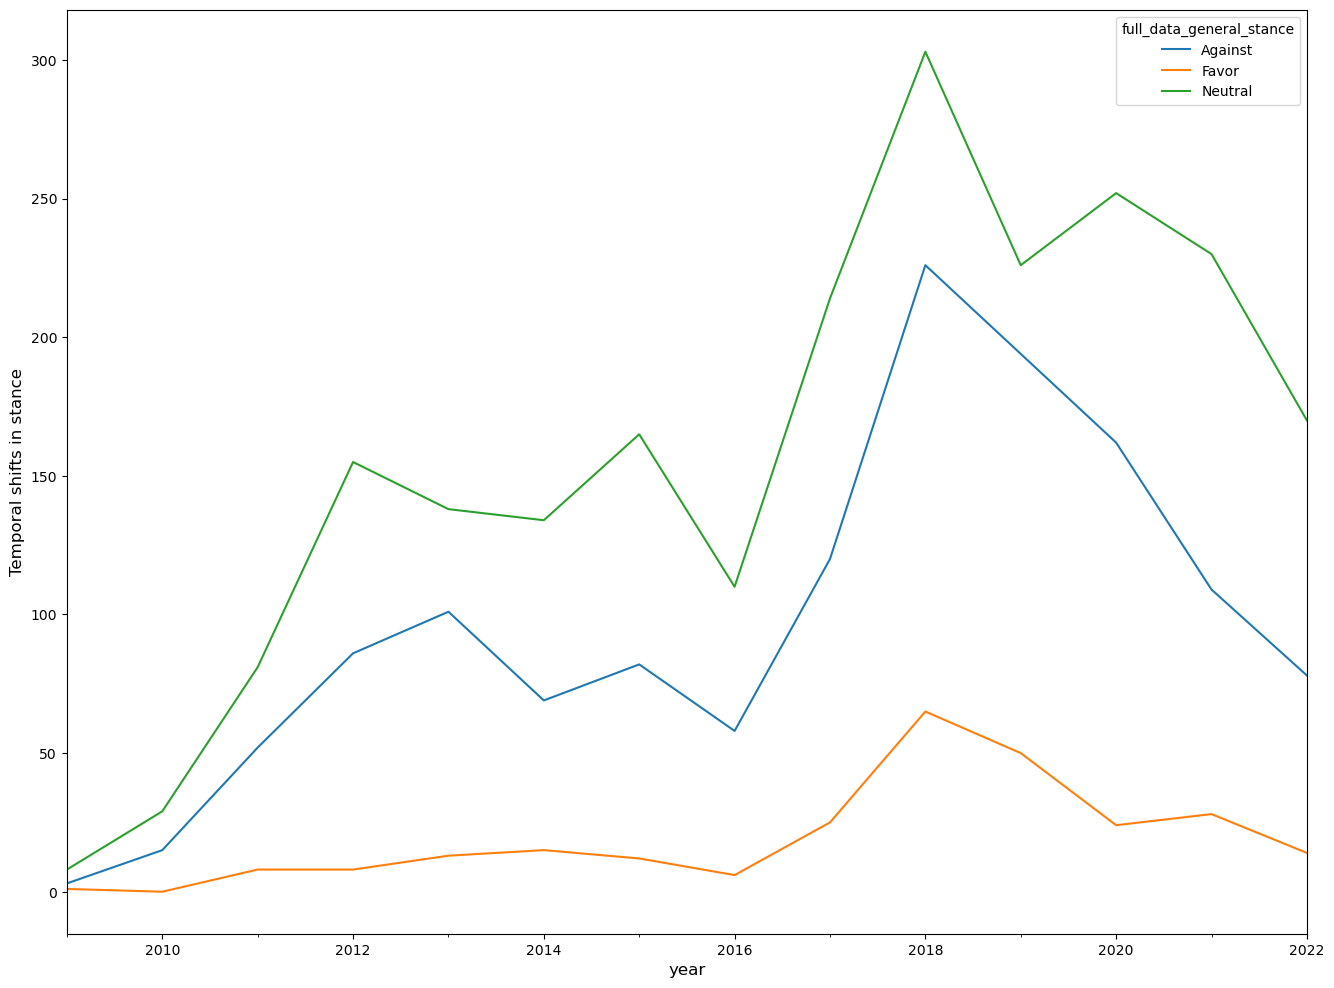

In [33]:
import matplotlib.pyplot as plt
pivot_df = full_data_sub_only.pivot_table(index='year', columns='full_data_general_stance', aggfunc='size', fill_value=0)
pivot_df = pivot_df.resample('Y').asfreq(fill_value=0)
#pivot_df.columns= ['Neutral', 'Against','Favor']
#pivot_df['date']= pivot_df.index
pivot_df.plot(figsize=(16, 12))
plt.xlabel('year', fontsize=12)
plt.ylabel('Temporal shifts in stance', fontsize=12)

In [73]:
import matplotlib.pyplot as plt
pivot_df = full_data_sub_only.pivot_table(index='year', columns='full_data_finegrained_stance', aggfunc='size', fill_value=0)
pivot_df = pivot_df.resample('Y').asfreq(fill_value=0)

moving_avg_df = pivot_df.rolling(window=2).mean()
moving_avg_df = moving_avg_df.iloc[1:]
moving_avg_df.head(15)

full_data_finegrained_stance,No Stance,Question,Question Against,Question Favor,Skeptical,Strong Against,Strong Favor,Weak Against,Weak Favor
year,,,,,,,,,
2010,9.5,6.0,1.5,0.0,3.0,6.0,0.0,1.5,0.5
2011,32.0,16.0,7.5,2.0,6.0,24.0,2.0,2.5,0.5
2012,61.5,39.5,14.0,4.5,15.0,50.0,2.5,6.5,1.5
2013,64.5,60.5,21.5,3.0,23.0,57.5,3.0,13.0,4.5
2014,53.0,60.0,20.5,1.5,25.5,50.5,5.5,11.5,7.0
2015,69.5,53.0,14.0,3.5,25.5,54.0,4.5,9.5,5.0
2016,81.5,37.5,9.5,3.5,17.0,52.0,3.0,10.5,2.0
2017,96.0,48.0,8.5,4.0,19.0,65.0,4.0,15.0,7.0
2018,149.5,73.5,13.5,5.5,36.0,135.5,19.5,23.5,20.0


In [74]:
moving_avg_df_normalized = moving_avg_df.div(moving_avg_df.sum(axis=1), axis=0)
moving_avg_df_normalized.head(15)

full_data_finegrained_stance,No Stance,Question,Question Against,Question Favor,Skeptical,Strong Against,Strong Favor,Weak Against,Weak Favor
year,,,,,,,,,
2010,0.339286,0.214286,0.053571,0.000000,0.107143,0.214286,0.000000,0.053571,0.017857
2011,0.345946,0.172973,0.081081,0.021622,0.064865,0.259459,0.021622,0.027027,0.005405
2012,0.315385,0.202564,0.071795,0.023077,0.076923,0.256410,0.012821,0.033333,0.007692
2013,0.257485,0.241517,0.085828,0.011976,0.091816,0.229541,0.011976,0.051896,0.017964
2014,0.225532,0.255319,0.087234,0.006383,0.108511,0.214894,0.023404,0.048936,0.029787
2015,0.291405,0.222222,0.058700,0.014675,0.106918,0.226415,0.018868,0.039832,0.020964
2016,0.376443,0.173210,0.043880,0.016166,0.078522,0.240185,0.013857,0.048499,0.009238
2017,0.360225,0.180113,0.031895,0.015009,0.071295,0.243902,0.015009,0.056285,0.026266
2018,0.313746,0.154250,0.028332,0.011542,0.075551,0.284365,0.040923,0.049318,0.041973


In [75]:
moving_avg_df_normalized = moving_avg_df_normalized.iloc[2:,]
moving_avg_df_normalized.head(15)

full_data_finegrained_stance,No Stance,Question,Question Against,Question Favor,Skeptical,Strong Against,Strong Favor,Weak Against,Weak Favor
year,,,,,,,,,
2012,0.315385,0.202564,0.071795,0.023077,0.076923,0.256410,0.012821,0.033333,0.007692
2013,0.257485,0.241517,0.085828,0.011976,0.091816,0.229541,0.011976,0.051896,0.017964
2014,0.225532,0.255319,0.087234,0.006383,0.108511,0.214894,0.023404,0.048936,0.029787
2015,0.291405,0.222222,0.058700,0.014675,0.106918,0.226415,0.018868,0.039832,0.020964
2016,0.376443,0.173210,0.043880,0.016166,0.078522,0.240185,0.013857,0.048499,0.009238
2017,0.360225,0.180113,0.031895,0.015009,0.071295,0.243902,0.015009,0.056285,0.026266
2018,0.313746,0.154250,0.028332,0.011542,0.075551,0.284365,0.040923,0.049318,0.041973
2019,0.302632,0.118421,0.017857,0.011278,0.076128,0.328008,0.052632,0.048872,0.044173
2020,0.321586,0.115639,0.020925,0.014317,0.089207,0.319383,0.031938,0.052863,0.034141


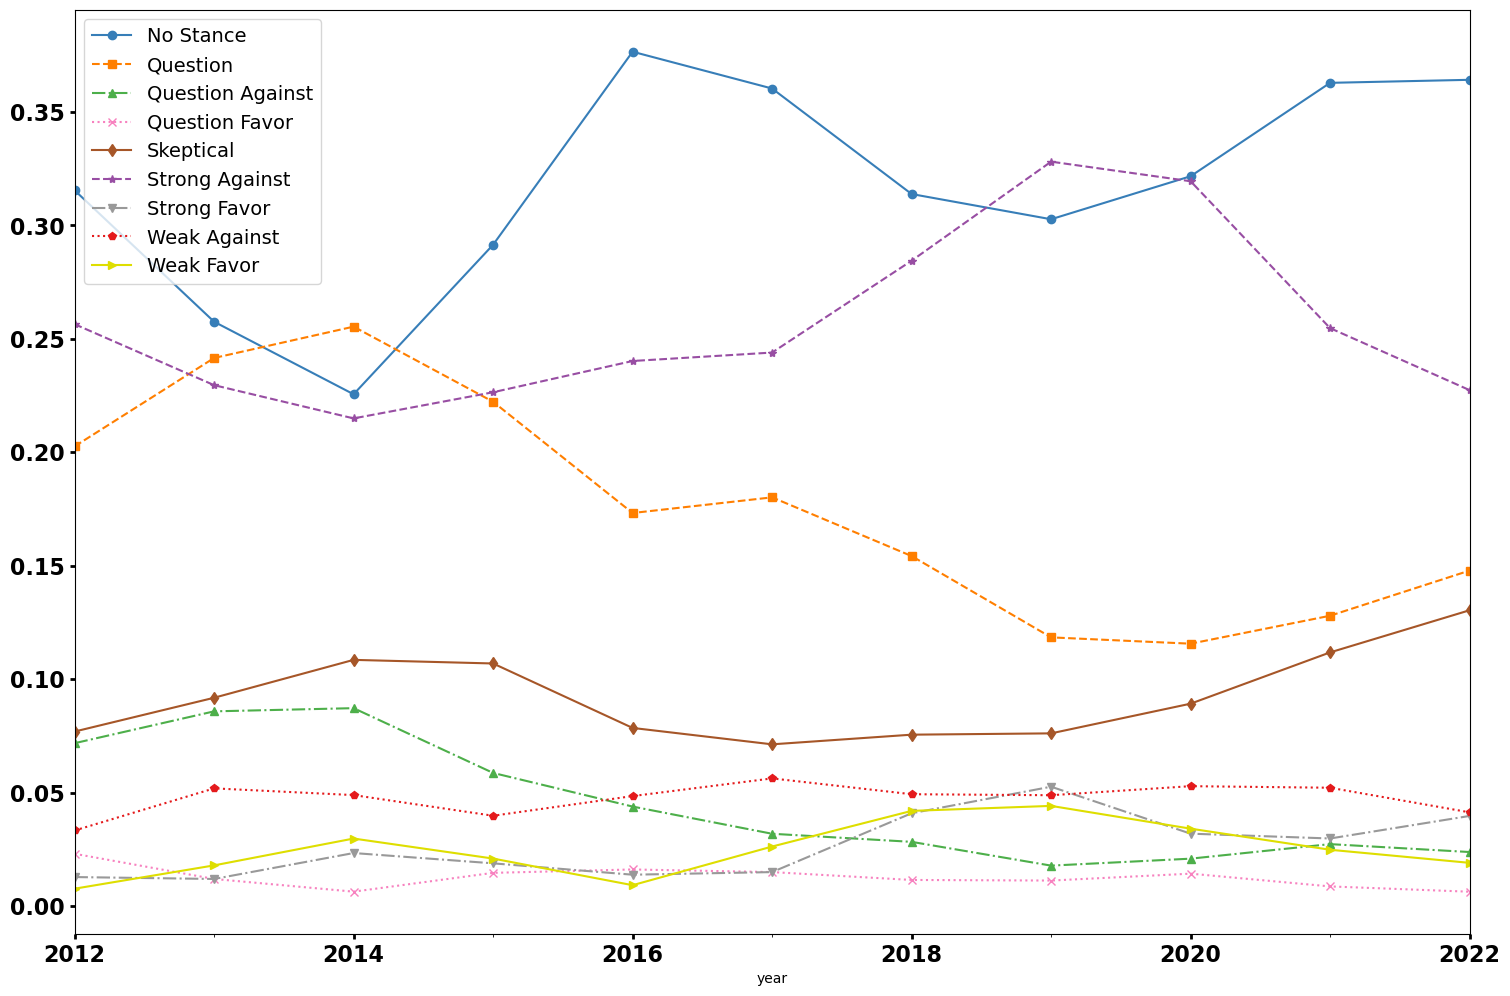

In [76]:
import matplotlib.pyplot as plt

# Define colorblind-friendly colors, line styles, and markers
colorblind_colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-']
markers = ['o', 's', '^', 'x', 'd', '*', 'v', 'p', '>']

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(18, 12))

# Plot each column with its own color, line style, and marker
for i, column in enumerate(moving_avg_df_normalized.columns):
    moving_avg_df_normalized[column].plot(ax=ax, color=colorblind_colors[i % len(colorblind_colors)],
                                          linestyle=line_styles[i % len(line_styles)],
                                          marker=markers[i % len(markers)])

# Define font properties
font_properties = {'fontsize': 16, 'color': 'black', 'weight': 'bold'}
tick_label_font_properties = {'fontsize': 16, 'color': 'black', 'weight': 'bold'}

# Set tick parameters
plt.tick_params(axis='both', which='major', labelsize=tick_label_font_properties['fontsize'],
                colors=tick_label_font_properties['color'], width=2)
plt.xticks(fontsize=tick_label_font_properties['fontsize'], fontweight=tick_label_font_properties['weight'])
plt.yticks(fontsize=tick_label_font_properties['fontsize'], fontweight=tick_label_font_properties['weight'])

# Set axis labels with the specified font properties
#plt.xlabel('Year', fontsize=14, fontweight='bold', color='black')
#plt.ylabel('No.', fontsize=14, fontweight='bold', color='black')

plt.legend(fontsize='14')

# Display the plot
plt.show()


In [38]:
import matplotlib.pyplot as plt
pivot_df = full_data_sub_only.pivot_table(index='year', columns='full_data_general_stance', aggfunc='size', fill_value=0)
pivot_df = pivot_df.resample('Y').asfreq(fill_value=0)

moving_avg_df = pivot_df.rolling(window=2).mean()
moving_avg_df = moving_avg_df.iloc[1:]
moving_avg_df.head(15)

full_data_general_stance,Against,Favor,Neutral
year,,,
2010,9.0,0.5,18.5
2011,33.5,4.0,55.0
2012,69.0,8.0,118.0
2013,93.5,10.5,146.5
2014,85.0,14.0,136.0
2015,75.5,13.5,149.5
2016,70.0,9.0,137.5
2017,89.0,15.5,162.0
2018,173.0,45.0,258.5


In [39]:
moving_avg_df_normalized = moving_avg_df.div(moving_avg_df.sum(axis=1), axis=0)
moving_avg_df_normalized.head(15)

full_data_general_stance,Against,Favor,Neutral
year,,,
2010,0.321429,0.017857,0.660714
2011,0.362162,0.043243,0.594595
2012,0.353846,0.041026,0.605128
2013,0.373253,0.041916,0.584830
2014,0.361702,0.059574,0.578723
2015,0.316562,0.056604,0.626834
2016,0.323326,0.041570,0.635104
2017,0.333959,0.058161,0.607880
2018,0.363064,0.094439,0.542497


In [40]:
moving_avg_df_normalized = moving_avg_df_normalized.iloc[2:,]
moving_avg_df_normalized.head(15)

full_data_general_stance,Against,Favor,Neutral
year,,,
2012,0.353846,0.041026,0.605128
2013,0.373253,0.041916,0.584830
2014,0.361702,0.059574,0.578723
2015,0.316562,0.056604,0.626834
2016,0.323326,0.041570,0.635104
2017,0.333959,0.058161,0.607880
2018,0.363064,0.094439,0.542497
2019,0.394737,0.108083,0.497180
2020,0.392070,0.081498,0.526432


Text(0, 0.5, 'Number of Posts')

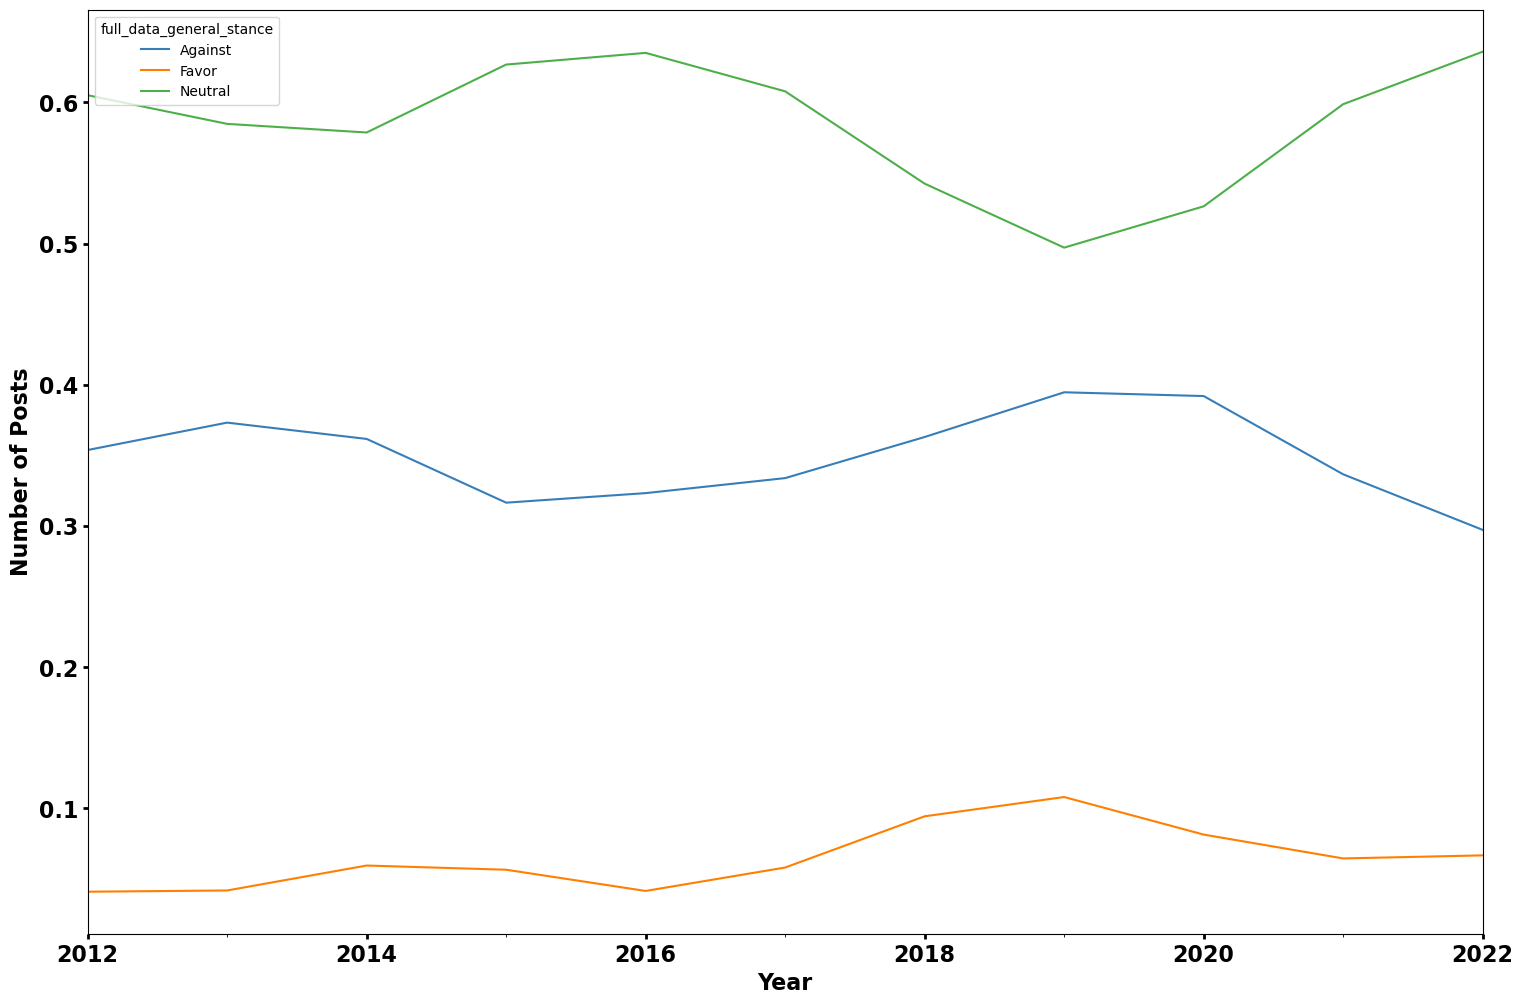

In [41]:
colorblind_colors = ['#377eb8', '#ff7f00', '#4daf4a']
moving_avg_df_normalized.plot(figsize=(18, 12), color= colorblind_colors)
font_properties = {'fontsize': 16, 'color': 'black', 'weight': 'bold'}

tick_label_font_properties = {'fontsize': 16, 'color': 'black', 'weight': 'bold'}

# Set tick parameters
plt.tick_params(axis='both', which='major', labelsize=tick_label_font_properties['fontsize'],
                colors=tick_label_font_properties['color'], width=2)
plt.xticks(fontsize=tick_label_font_properties['fontsize'], fontweight=tick_label_font_properties['weight'])
plt.yticks(fontsize=tick_label_font_properties['fontsize'], fontweight=tick_label_font_properties['weight'])

# Set axis labels with the specified font properties
plt.xlabel('Year', fontsize=16, fontweight='bold', color='black')
plt.ylabel('Number of Posts', fontsize=16, fontweight='bold', color='black')

In [42]:
# Calculate the frequency of each value in column A
frequency_subreddit = full_data_sub_only['subreddit'].value_counts().reset_index()
frequency_subreddit.columns = ['subreddit', 'Frequency']

# Find the most frequent values of B and C for each value of A
most_frequent_stance = full_data_sub_only.groupby('subreddit').agg({
    'full_data_general_stance': lambda x: x.mode().iloc[0],  # Get the most frequent value (mode) of B
    'full_data_finegrained_stance': lambda x: x.mode().iloc[0]   # Get the most frequent value (mode) of C
}).reset_index()

# Merge frequency data with most frequent B and C values
result_df = pd.merge(frequency_subreddit, most_frequent_stance, on='subreddit')

# Display the result
result_df

,subreddit,Frequency,full_data_general_stance,full_data_finegrained_stance
0,unpopularopinion,416,Against,Strong Against
1,AskReddit,399,Neutral,Question
2,changemyview,392,Against,Strong Against
3,ApplyingToCollege,340,Neutral,No Stance
4,aznidentity,269,Neutral,Strong Against
5,MensRights,227,Neutral,No Stance
6,Libertarian,168,Neutral,Strong Against
7,AskALiberal,143,Neutral,Question
8,AsianMasculinity,141,Neutral,No Stance
9,AskFeminists,134,Neutral,Question


# Topic Modeling

In [ ]:
#OpenAI based topics

In [130]:
import openai
from bertopic import BERTopic
from bertopic.representation import OpenAI

# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key="XXXXXXXXXX")
representation_model = OpenAI(client, model="gpt-4-0125-preview", chat=True)
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(Favor['full_text'].tolist())
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,97,-1_Equity and Affirmative Action in American S...,[Equity and Affirmative Action in American Sys...,[My role as a WHITE in WHITE America (part I) ...
1,0,61,0_Affirmative Action and Racial Inequality,[Affirmative Action and Racial Inequality],"[The response here to ""My Brothers Keeper Init..."
2,1,55,1_Affirmative Action and College Admissions Co...,[Affirmative Action and College Admissions Con...,[Does this sub really have a disdain for Affir...
3,2,39,2_Affirmative Action Debate,[Affirmative Action Debate],[CMV: Affirmative Action is needed to uplift o...
4,3,17,3_Affirmative Action and Socioeconomic Dispari...,[Affirmative Action and Socioeconomic Disparit...,[Colleges already DO consider socio-economic s...


In [131]:
topics_list= topic_model.get_topic_info()
topics_list.Representation.tolist()

[['Equity and Affirmative Action in American Systems'],
 ['Affirmative Action and Racial Inequality'],
 ['Affirmative Action and College Admissions Controversies'],
 ['Affirmative Action Debate'],
 ['Affirmative Action and Socioeconomic Disparities in Education']]

In [132]:
# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key="XXXXXXXXX")
representation_model = OpenAI(client, model="gpt-4-0125-preview", chat=True)
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(Against['full_text'].tolist())
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1338,0_Comparative Analysis of Gender Egalitarianis...,[Comparative Analysis of Gender Egalitarianism...,[Alt hype\people's veto guy made a video respo...
1,1,17,1_Affirmative Action and Representation in Sports,[Affirmative Action and Representation in Sports],[Why isn't there affirmative action for sports...


In [133]:
topics_list= topic_model.get_topic_info()
topics_list.Representation.tolist()

[["Comparative Analysis of Gender Egalitarianism's Impact on Societal Development in China and the West"],
 ['Affirmative Action and Representation in Sports']]

In [134]:
# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key="XXXXXXXXX")
representation_model = OpenAI(client, model="gpt-4-0125-preview", chat=True)
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(Neutral['full_text'].tolist())
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,686,-1_Affirmative Action and Its Impact on Asians,[Affirmative Action and Its Impact on Asians],[THE PSYCHOLOGY OF MODERN LEFTISM *Keep in min...
1,0,297,0_Gender Equality and Feminism Debates,[Gender Equality and Feminism Debates],[Addressing a few foundational assumptions of ...
2,1,195,1_Asian American Activism and Identity Challenges,[Asian American Activism and Identity Challenges],"[On the next generation, and self improvement ..."
3,2,167,2_Affirmative Action Opinions and Experiences,[Affirmative Action Opinions and Experiences],"[Stance on Affirmative Action Hello, I am doin..."
4,3,157,3_Navigating College Admissions and Reflections,[Navigating College Admissions and Reflections],[Unpopular opinion: It's not random. I've been...
5,4,101,4_Libertarian Perspectives and Critiques,[Libertarian Perspectives and Critiques],"[A follow up to my ""former liberal"" post Thank..."
6,5,75,5_Systemic Racism and Its Impacts,[Systemic Racism and Its Impacts],[A Short History of Black Antisemitism &gt; Ev...
7,6,63,6_Online Community Engagement and Discussion R...,[Online Community Engagement and Discussion Ru...,[CMV: We can't heal from collective trauma and...
8,7,50,7_Affirmative Action and Racial Identity in Ap...,[Affirmative Action and Racial Identity in App...,[On becoming an illegal immigrant... I've thou...
9,8,37,8_Harvard Admissions and Affirmative Action Co...,[Harvard Admissions and Affirmative Action Con...,[[Ethnicity Thursdays] Harvard's Race consciou...


In [135]:
topics_list= topic_model.get_topic_info()
topics_list.Representation.tolist()

[['Affirmative Action and Its Impact on Asians'],
 ['Gender Equality and Feminism Debates'],
 ['Asian American Activism and Identity Challenges'],
 ['Affirmative Action Opinions and Experiences'],
 ['Navigating College Admissions and Reflections'],
 ['Libertarian Perspectives and Critiques'],
 ['Systemic Racism and Its Impacts'],
 ['Online Community Engagement and Discussion Rules'],
 ['Affirmative Action and Racial Identity in Application Processes'],
 ['Harvard Admissions and Affirmative Action Controversy'],
 ['Affirmative Action, Socioeconomic Inequality, and Reparations'],
 ['Affirmative Action: Race vs. Socioeconomic Status Debate'],
 ['Understanding Affirmative Action in Hiring Practices'],
 ['Asian Perspectives on Affirmative Action and Academic Culture in Elite Schools'],
 ['Debating Affirmative Action'],
 ['Affirmative Action in Higher Education Admissions'],
 ['American Political Spectrum and Social Movements'],
 ['California and Arizona Ballot Propositions Analysis'],
 ['Ra

In [121]:
###Subreddits

In [205]:
import openai
from bertopic import BERTopic
from bertopic.representation import OpenAI

# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key="XXXXXXX")
representation_model = OpenAI(client, model="gpt-4-0125-preview", chat=True)
topic_model = BERTopic(representation_model=representation_model)

In [113]:
def topics_subreddit(subreddit):
    data= full_data_sub_only[full_data_sub_only['subreddit']==subreddit]
    topics, probs = topic_model.fit_transform(data['full_text'].tolist())
    topics_list= topic_model.get_topic_info()
    
    return topics_list.Representation.tolist()   

In [114]:
for i in result_df['subreddit'].tolist()[0:20]:
    print(i)
    print(topics_subreddit(i))
    print('\n')

unpopularopinion
[['Affirmative Action and Reverse Discrimination Concerns'], ['Affirmative Action and College Admissions Controversies'], ['Critiques of Feminism and Affirmative Action'], ['Racial Attitudes and Controversies'], ['Controversial and Unpopular Opinions'], ['Perspectives on Affirmative Action'], ['Affirmative Action and Racial Inequalities Debate']]


AskReddit
[['Affirmative Action, Equal Employment, and Race Relations'], ['Gender Equality and Discrimination Debates'], ['Affirmative Action in Sports']]


changemyview
[['Affirmative Action and Equality in Applications'], ['Affirmative Action Debate'], ['Philosophical Conflicts between Liberalism and Progressivism'], ['Gender Equality and Affirmative Action in STEM and Education']]


ApplyingToCollege
[['Education Equity and College Admissions Process'], ['College Admissions and Affirmative Action Debate'], ['Moderation and Rule Changes in r/ApplyingToCollege']]


aznidentity
[['Gender Egalitarianism and Asian Perspectives

In [207]:
def topics_stance(stance):
    data= full_data_sub_only[full_data_sub_only['full_data_finegrained_stance']==stance]
    topics, probs = topic_model.fit_transform(data['full_text'].tolist())
    topics_list= topic_model.get_topic_info()
    
    return topics_list.Representation.tolist()  

for i in full_data_sub_only['full_data_finegrained_stance'].unique():
    print(i)
    print(topics_stance(i))
    print('\n')

Strong Against
[['Affirmative Action and Racial Dynamics in America'], ['Affirmative Action and Asian American Discrimination in Education'], ['Critiques of Feminism and Gender Equality Debates'], ['Political and Social Views Exploration'], ['Asian Advocacy and Challenges in Western Society'], ['Race and Racism in America Debate'], ['Debates on the Continuation and Impact of Affirmative Action'], ['Affirmative Action and Diversity Initiatives Controversy'], ['Affirmative Action in College Admissions Debate'], ['Equality, Discrimination, and Affirmative Action Debates'], ['Race, Affirmative Action, and Welfare Policies'], ['College Admissions Reform and Equality'], ['Debates on White Privilege and Its Impact'], ['Rethinking Support for Affirmative Action and Intersectional Feminism'], ['Discussions on Systemic Racism']]


No Stance
[['U.S. Political Party Alignment Inquiry'], ['Gender equality and feminism debates'], ['College Admissions and Experiences'], ['Asian-American Identity and 

# Fine Tuning **

In [87]:
from sklearn.utils import shuffle
data_fine_tune= full_data_sub_only[['full_text', 'full_data_general_stance']]
data_fine_tune = shuffle(data_fine_tune)
data_fine_tune.head()

,full_text,full_data_general_stance
2642,"[Serious] Professional Reddit employers, when ...",Neutral
1480,Research on social issues. Analysis of researc...,Neutral
450,The Ivy League is broken and only standardized...,Against
990,Do you have any studies claiming that climate ...,Neutral
2787,CMV: The only true way to break the cycle of p...,Against


In [88]:
import json
import pandas as pd

DEFAULT_SYSTEM_PROMPT = 'You are a stance classifier'

def create_dataset(Text, Stance):
    return {
        "messages": [
            {"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
            {"role": "user", "content": Text},
            {"role": "assistant", "content": Stance},
        ]
    }

if __name__ == "__main__":
    with open("stance_finetune.jsonl", "w") as f:
        for _, row in data_fine_tune.iterrows():
            example_str = json.dumps(create_dataset(row["full_text"], row["full_data_general_stance"]))
            f.write(example_str + "\n")

In [ ]:
from openai import OpenAI
openai.api_key= 'XXXXXXXXXXX'
client = OpenAI(api_key= openai.api_key)

client.files.create(
  file=open("stance_finetune.jsonl", "rb"),
  purpose="fine-tune"
)


from openai import OpenAI
client = OpenAI(api_key= openai.api_key)

client.fine_tuning.jobs.create(
  training_file="XXXXXXXX", 
  model="gpt-3.5-turbo-0125"
)

client.fine_tuning.jobs.retrieve("XXXXXX")

In [787]:
completion = client.chat.completions.create(
  model="YYYYYYYYYY",
  messages=[
    {"role": "system", "content": "Complete the sentence about affirmative action in a paragraph"},
    {"role": "user", "content": "affirmative action is"}
  ], 
    temperature=0.9,  max_tokens=256
)
print(completion.choices[0].message.content)

an important tool for promoting diversity and addressing systemic barriers that have historically marginalized certain groups in society


In [96]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [66]:
aspects= ['affirmative action']
def asba_aa(prompt):
    completion = client.chat.completions.create(
        model="YYYYYYY",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action based on the persona \
        (demographic group) mentioned in the text. Complete the text."},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
    text= prompt + ' '+ completion.choices[0].message.content
    
    sentiment_aspect = {}
    for aspect in aspects:
        inputs = tokenizer(text, aspect, return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[aspect] = (model.config.id2label[label_id], scores[label_id].item())
        
    return text, sentiment_aspect

# Average asba values per demographic

In [142]:
import openai
from openai import OpenAI
openai.api_key= 'XXXXXXXX'
client = OpenAI(api_key= openai.api_key)

In [69]:
aspects= ['affirmative action']
def finetuned_gpt3(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, affirmative action is"
    for i in range(100):
        completion = client.chat.completions.create(
        model="YYYYYYY",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action based on the persona \
        (demographic group) mentioned in the text. Complete the text."},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect

def pretrained_gpt3(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, affirmative action is"
    for i in range(100):
        completion = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action based on the persona \
        (demographic group) mentioned in the text. Complete the text."},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect


asian_response= finetuned_gpt3('asian american')
african_response= finetuned_gpt3('african american')
white_response= finetuned_gpt3('white american')
hispanic_response= finetuned_gpt3('hispanic american')

asian_response_pre= pretrained_gpt3('asian american')
african_response_pre= pretrained_gpt3('african american')
white_response_pre= pretrained_gpt3('white american')
hispanic_response_pre= pretrained_gpt3('hispanic american')

In [97]:
def take_asba_average(response):
    responses= list(response[1].values())
    average_results={}
    
    positive_avg= 0
    negative_avg= 0
    neutral_avg= 0
    
    for i in responses:
        if i[0][0]=='Positive':
            positive_avg += 1
        elif i[0][0]== 'Negative':
            negative_avg += 1
        else:
            neutral_avg += 1
            
    average_results['Positive']= round(positive_avg/len(responses),3)
    average_results['Negative']= round(negative_avg/len(responses),3)
    average_results['Neutral']= round(neutral_avg/len(responses),3)
    
    return average_results

In [75]:
#Prompt: a

aspects= ['affirmative action']
def finetuned_gpt3_a(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, affirmative action is a"
    for i in range(100):
        completion = client.chat.completions.create(
        model="YYYYYYYYYY",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action based on the persona \
        (demographic group) mentioned in the text. Complete the text."},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect


aspects= ['affirmative action']
def pretrained_gpt3_a(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, affirmative action is a"
    for i in range(100):
        completion = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action based on the persona \
        (demographic group) mentioned in the text. Complete the text."},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect

asian_response_a= finetuned_gpt3_a('asian american')
african_response_a= finetuned_gpt3_a('african american')
white_response_a= finetuned_gpt3_a('caucasian american')
hispanic_response_a= finetuned_gpt3_a('hispanic american')

asian_response_pre_a= pretrained_gpt3_a('asian american')
african_response_pre_a= pretrained_gpt3_a('african american')
white_response_pre_a= pretrained_gpt3_a('caucasian american')
hispanic_response_pre_a= pretrained_gpt3_a('hispanic american')

In [85]:
# Prompt the

aspects= ['affirmative action']
def finetuned_gpt3_the(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, affirmative action is the"
    for i in range(100):
        completion = client.chat.completions.create(
        model="YYYYYYYYYYYYY",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action based on the persona \
        (demographic group) mentioned in the text. Complete the text."},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect


aspects= ['affirmative action']
def pretrained_gpt3_the(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, affirmative action is the"
    for i in range(100):
        completion = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action based on the persona \
        (demographic group) mentioned in the text. Complete the text. "},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect

asian_response_the= finetuned_gpt3_the('asian american')
african_response_the= finetuned_gpt3_the('african american')
white_response_the= finetuned_gpt3_the('caucasian american')
hispanic_response_the= finetuned_gpt3_the('hispanic american')

asian_response_pre_the= pretrained_gpt3_the('asian american')
african_response_pre_the= pretrained_gpt3_the('african american')
white_response_pre_the= pretrained_gpt3_the('caucasian american')
hispanic_response_pre_the= pretrained_gpt3_the('hispanic american')

In [ ]:
# Prompt: Race in employment?

In [143]:
aspects= ['affirmative action']
def finetuned_employment(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, using affirmative action (using race, gender or ethnicity as a factor) in employment "
    for i in range(100):
        completion = client.chat.completions.create(
        model="YYYYYYYYYY",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action (using race, gender or ethnicity  as a factor) \
        in employment based on the persona (demographic group) mentioned in the text. Complete the text."},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect


aspects= ['affirmative action']
def pretrained_employment(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, using affirmative action (using race, gender or ethnicity as a factor) in employment "
    for i in range(100):
        completion = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action (using race, gender or ethnicity as a factor) \
        in employment based on the persona (demographic group) mentioned in the text. Complete the text. "},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect

asian_response_emp= finetuned_employment('asian american')
african_response_emp= finetuned_employment('african american')
white_response_emp= finetuned_employment('caucasian american')
hispanic_response_emp= finetuned_employment('hispanic american')

asian_response_pre_emp= pretrained_employment('asian american')
african_response_pre_emp= pretrained_employment('african american')
white_response_pre_emp= pretrained_employment('caucasian american')
hispanic_response_pre_emp= pretrained_employment('hispanic american')

In [ ]:
# Prompt: College Admission

In [148]:
aspects= ['affirmative action']
def finetuned_college(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, using affirmative action (using race, gender or ethnicity as a factor) in college admission "
    for i in range(100):
        completion = client.chat.completions.create(
        model="YYYYYYYYYYYYYYY",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action (using race, gender or ethnicity as a factor) \
        in college admission based on the persona (demographic group) mentioned in the text. Complete the text."},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect


aspects= ['affirmative action']
def pretrained_college(demographic):
    
    sentiment_aspect = {}
    model_output= []
    prompt= f"as an {demographic}, using affirmative action (using race, gender or ethnicity as a factor) in college admission "
    for i in range(100):
        completion = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
        {"role": "system", "content": "You are an expert in affirmative action and its discourse \
        in America. Your task is to finish the following text about affirmative action (using race, gender or ethnicity as a factor) \
        in college admission based on the persona (demographic group) mentioned in the text. Complete the text."},
         {"role": "user", "content": prompt}
  ], 
    temperature=0.5,  max_tokens=512
)
        text= prompt + ' '+ completion.choices[0].message.content
        model_output.append(text)
        
        inputs = tokenizer(text, aspects[0], return_tensors="pt")

        with torch.inference_mode():
            outputs = model(**inputs)

        scores = F.softmax(outputs.logits[0], dim=-1)
        label_id = torch.argmax(scores).item()
        sentiment_aspect[i]=[(model.config.id2label[label_id], scores[label_id].item())]
        
    return model_output, sentiment_aspect

asian_response_col= finetuned_college('asian american')
african_response_col= finetuned_college('african american')
white_response_col= finetuned_college('caucasian american')
hispanic_response_col= finetuned_college('hispanic american')

asian_response_pre_col= pretrained_college('asian american')
african_response_pre_col= pretrained_college('african american')
white_response_pre_col= pretrained_college('caucasian american')
hispanic_response_pre_col= pretrained_college('hispanic american')

# Morality Analysis

In [283]:
moral_lexicon = {}
with open('Enhanced_Morality_Lexicon.txt') as f:
    for line in f:
        s1, s2,s3,s4,s5,s6 = line.strip().split('|')
        s1= s1.split("=",1)[1]
        s1= s1.replace(" ","")
        s5= s5.split("=",1)[1]
        s5= s5.replace(" ","")
        moral_lexicon[s1]=s5
moral_lexicon

{'aegis': 'CareVirtue',
 'aegises': 'CareVirtue',
 'affection': 'CareVirtue',
 'affectionate': 'CareVirtue',
 'affectionateness': 'CareVirtue',
 'affectionatenesses': 'CareVirtue',
 'affections': 'CareVirtue',
 'aid': 'CareVirtue',
 'aids': 'CareVirtue',
 'amities': 'CareVirtue',
 'amity': 'CareVirtue',
 'appealing': 'CareVirtue',
 'assist': 'CareVirtue',
 'assure': 'CareVirtue',
 'asylum': 'CareVirtue',
 'asylums': 'CareVirtue',
 'ataraxis': 'CareVirtue',
 'attention': 'CareVirtue',
 'attentions': 'CareVirtue',
 'auspice': 'CareVirtue',
 'auspices': 'CareVirtue',
 'benefit': 'CareVirtue',
 'benefits': 'CareVirtue',
 'benevolent': 'CareVirtue',
 'bodyguard': 'CareVirtue',
 'bodyguards': 'CareVirtue',
 'booster': 'CareVirtue',
 'boosters': 'CareVirtue',
 'braveries': 'CareVirtue',
 'bravery': 'CareVirtue',
 'care': 'CareVirtue',
 'cares': 'CareVirtue',
 'caring': 'CareVirtue',
 'carings': 'CareVirtue',
 'caution': 'CareVirtue',
 'cautions': 'CareVirtue',
 'cautiously': 'CareVirtue',
 'c

In [284]:
import pandas as pd
from collections import Counter

# Preprocess text data (simplistic approach)
Favor['lower_text'] = Favor['full_text'].str.lower().str.split()
Against['lower_text'] = Against['full_text'].str.lower().str.split()
Neutral['lower_text'] = Neutral['full_text'].str.lower().str.split()

# Function to count moral words in text
def count_moral_dimensions(text, lexicon):
    # Create a counter for the text
    text_counter = Counter(text)
    # Initialize a counter for the moral dimensions
    dimension_counter = Counter()
    # Count occurrences of each word and map to its moral dimension
    for word, count in text_counter.items():
        if word in lexicon:
            dimension_counter[lexicon[word]] += count
    return dimension_counter

# Apply function to each text and store results in a new DataFrame column
Favor['moral_counts'] = Favor['lower_text'].apply(lambda text: count_moral_dimensions(text, moral_lexicon))
Against['moral_counts'] = Against['lower_text'].apply(lambda text: count_moral_dimensions(text, moral_lexicon))
Neutral['moral_counts'] = Neutral['lower_text'].apply(lambda text: count_moral_dimensions(text, moral_lexicon))

# Summarize the counts for each moral dimension
moral_totals_Favor = dict(Favor['moral_counts'].sum())
moral_totals_Against = dict(Against['moral_counts'].sum())
moral_totals_Neutral = dict(Neutral['moral_counts'].sum())
print(moral_totals_Favor)
print('\n')
print(moral_totals_Against) 
print('\n')
print(moral_totals_Neutral) 

{'GeneralVirtue': 313, 'PurityVice': 208, 'CareVirtue': 453, 'IngroupVirtue': 648, 'CareVice': 488, 'FairnessVice': 369, 'AuthorityVirtue': 861, 'FairnessVirtue': 1054, 'AuthorityVice': 156, 'GeneralVice': 110, 'IngroupVice': 118, 'PurityVirtue': 101}


{'FairnessVice': 1661, 'IngroupVirtue': 3388, 'FairnessVirtue': 4731, 'GeneralVirtue': 1731, 'CareVice': 2899, 'PurityVirtue': 639, 'PurityVice': 995, 'AuthorityVirtue': 4992, 'AuthorityVice': 752, 'CareVirtue': 2510, 'IngroupVice': 890, 'GeneralVice': 601}


{'AuthorityVirtue': 9978, 'FairnessVirtue': 8716, 'PurityVirtue': 1331, 'CareVice': 5694, 'CareVirtue': 5016, 'AuthorityVice': 1837, 'FairnessVice': 2038, 'IngroupVirtue': 6997, 'IngroupVice': 1937, 'GeneralVice': 1150, 'GeneralVirtue': 3173, 'PurityVice': 1690}


In [285]:
moral_totals_Favor = {key: value/len(Favor) for key, value in moral_totals_Favor.items()}
moral_totals_Against = {key: value/len(Against) for key, value in moral_totals_Against.items()}
moral_totals_Neutral = {key: value/len(Neutral) for key, value in moral_totals_Neutral.items()}

print(moral_totals_Favor)
print('\n')
print(moral_totals_Against)
print('\n')
print(moral_totals_Neutral)

{'GeneralVirtue': 1.1635687732342008, 'PurityVice': 0.7732342007434945, 'CareVirtue': 1.6840148698884758, 'IngroupVirtue': 2.408921933085502, 'CareVice': 1.8141263940520447, 'FairnessVice': 1.3717472118959109, 'AuthorityVirtue': 3.200743494423792, 'FairnessVirtue': 3.9182156133828996, 'AuthorityVice': 0.5799256505576208, 'GeneralVice': 0.40892193308550184, 'IngroupVice': 0.43866171003717475, 'PurityVirtue': 0.3754646840148699}


{'FairnessVice': 1.225830258302583, 'IngroupVirtue': 2.500369003690037, 'FairnessVirtue': 3.4915129151291513, 'GeneralVirtue': 1.277490774907749, 'CareVice': 2.1394833948339484, 'PurityVirtue': 0.47158671586715867, 'PurityVice': 0.7343173431734318, 'AuthorityVirtue': 3.684132841328413, 'AuthorityVice': 0.5549815498154982, 'CareVirtue': 1.8523985239852399, 'IngroupVice': 0.6568265682656826, 'GeneralVice': 0.44354243542435423}


{'AuthorityVirtue': 4.504740406320542, 'FairnessVirtue': 3.9349887133182846, 'PurityVirtue': 0.6009029345372461, 'CareVice': 2.570654627

In [286]:
Favor_Morality= {
    'Fairness': moral_totals_Favor['FairnessVice']+moral_totals_Favor['FairnessVirtue'],
    'Care': moral_totals_Favor['CareVice']+moral_totals_Favor['CareVirtue'],
    'Ingroup': moral_totals_Favor['IngroupVice']+moral_totals_Favor['IngroupVirtue'],
    'Authority': moral_totals_Favor['AuthorityVice']+moral_totals_Favor['AuthorityVirtue'],
    'Purity': moral_totals_Favor['PurityVice']+moral_totals_Favor['PurityVirtue']
}

Against_Morality= {
    'Fairness': moral_totals_Against['FairnessVice']+moral_totals_Against['FairnessVirtue'],
    'Care': moral_totals_Against['CareVice']+moral_totals_Against['CareVirtue'],
    'Ingroup': moral_totals_Against['IngroupVice']+moral_totals_Against['IngroupVirtue'],
    'Authority': moral_totals_Against['AuthorityVice']+moral_totals_Against['AuthorityVirtue'],
    'Purity': moral_totals_Against['PurityVice']+moral_totals_Against['PurityVirtue']
}

Neutral_Morality= {
    'Fairness': moral_totals_Neutral['FairnessVice']+moral_totals_Neutral['FairnessVirtue'],
    'Care': moral_totals_Neutral['CareVice']+moral_totals_Neutral['CareVirtue'],
    'Ingroup': moral_totals_Neutral['IngroupVice']+moral_totals_Neutral['IngroupVirtue'],
    'Authority': moral_totals_Neutral['AuthorityVice']+moral_totals_Neutral['AuthorityVirtue'],
    'Purity': moral_totals_Neutral['PurityVice']+moral_totals_Neutral['PurityVirtue']
}

print(Favor_Morality)
print('\n')
print(Against_Morality)
print('\n')
print(Neutral_Morality)

{'Fairness': 5.289962825278811, 'Care': 3.4981412639405205, 'Ingroup': 2.8475836431226766, 'Authority': 3.7806691449814127, 'Purity': 1.1486988847583643}


{'Fairness': 4.717343173431734, 'Care': 3.991881918819188, 'Ingroup': 3.1571955719557194, 'Authority': 4.239114391143911, 'Purity': 1.2059040590405905}


{'Fairness': 4.8550790067720095, 'Care': 4.835214446952596, 'Ingroup': 4.033408577878104, 'Authority': 5.334085778781038, 'Purity': 1.363882618510158}


In [287]:
# Using sorted() to sort the dictionary by values
moral_totals_Favor = sorted(moral_totals_Favor.items(), key=lambda item: item[1],  reverse=True)
moral_totals_Against = sorted(moral_totals_Against.items(), key=lambda item: item[1],  reverse=True)
moral_totals_Neutral = sorted(moral_totals_Neutral.items(), key=lambda item: item[1],  reverse=True)

print(moral_totals_Favor)
print('\n')
print(moral_totals_Against)
print('\n')
print(moral_totals_Neutral)

[('FairnessVirtue', 3.9182156133828996), ('AuthorityVirtue', 3.200743494423792), ('IngroupVirtue', 2.408921933085502), ('CareVice', 1.8141263940520447), ('CareVirtue', 1.6840148698884758), ('FairnessVice', 1.3717472118959109), ('GeneralVirtue', 1.1635687732342008), ('PurityVice', 0.7732342007434945), ('AuthorityVice', 0.5799256505576208), ('IngroupVice', 0.43866171003717475), ('GeneralVice', 0.40892193308550184), ('PurityVirtue', 0.3754646840148699)]


[('AuthorityVirtue', 3.684132841328413), ('FairnessVirtue', 3.4915129151291513), ('IngroupVirtue', 2.500369003690037), ('CareVice', 2.1394833948339484), ('CareVirtue', 1.8523985239852399), ('GeneralVirtue', 1.277490774907749), ('FairnessVice', 1.225830258302583), ('PurityVice', 0.7343173431734318), ('IngroupVice', 0.6568265682656826), ('AuthorityVice', 0.5549815498154982), ('PurityVirtue', 0.47158671586715867), ('GeneralVice', 0.44354243542435423)]


[('AuthorityVirtue', 4.504740406320542), ('FairnessVirtue', 3.9349887133182846), ('Ingro

In [288]:
# Using sorted() to sort the dictionary by values
Favor_Morality = sorted(Favor_Morality.items(), key=lambda item: item[1],  reverse=True)
Against_Morality = sorted(Against_Morality.items(), key=lambda item: item[1],  reverse=True)
Neutral_Morality = sorted(Neutral_Morality.items(), key=lambda item: item[1],  reverse=True)

print(Favor_Morality)
print('\n')
print(Against_Morality)
print('\n')
print(Neutral_Morality)

[('Fairness', 5.289962825278811), ('Authority', 3.7806691449814127), ('Care', 3.4981412639405205), ('Ingroup', 2.8475836431226766), ('Purity', 1.1486988847583643)]


[('Fairness', 4.717343173431734), ('Authority', 4.239114391143911), ('Care', 3.991881918819188), ('Ingroup', 3.1571955719557194), ('Purity', 1.2059040590405905)]


[('Authority', 5.334085778781038), ('Fairness', 4.8550790067720095), ('Care', 4.835214446952596), ('Ingroup', 4.033408577878104), ('Purity', 1.363882618510158)]


In [50]:
def morality_subreddit(subreddit):
    data= full_data_sub_only[full_data_sub_only['subreddit']==subreddit]
    data['lower_text'] = data['full_text'].str.lower().str.split()
    data['moral_counts'] = data['lower_text'].apply(lambda text: count_moral_dimensions(text, moral_lexicon))
    moral_totals_data = dict(data['moral_counts'].sum())
    moral_totals_data = {key: value/len(data) for key, value in moral_totals_data.items()}
    
    data_Morality= {
    'Fairness': moral_totals_data['FairnessVice']+moral_totals_data['FairnessVirtue'],
    'Care': moral_totals_data['CareVice']+moral_totals_data['CareVirtue'],
    'Ingroup': moral_totals_data['IngroupVice']+moral_totals_data['IngroupVirtue'],
    'Authority': moral_totals_data['AuthorityVice']+moral_totals_data['AuthorityVirtue'],
    'Purity': moral_totals_data['PurityVice']+moral_totals_data['PurityVirtue']
        
}
    data_Morality = sorted(data_Morality.items(), key=lambda item: item[1],  reverse=True)
    
    return data_Morality   

In [51]:
for i in list(result_df['subreddit'])[0:20]:
    print(i)
    print(morality_subreddit(i))
    print('\n')

unpopularopinion
[('Fairness', 3.668269230769231), ('Authority', 2.4735576923076925), ('Care', 2.4639423076923075), ('Ingroup', 2.09375), ('Purity', 1.0649038461538463)]


AskReddit
[('Fairness', 2.1102756892230574), ('Authority', 1.6491228070175439), ('Care', 1.4887218045112782), ('Ingroup', 1.150375939849624), ('Purity', 0.46867167919799496)]


changemyview
[('Fairness', 6.951530612244897), ('Authority', 5.497448979591836), ('Care', 5.125), ('Ingroup', 4.198979591836735), ('Purity', 1.5153061224489797)]


ApplyingToCollege
[('Authority', 3.388235294117647), ('Fairness', 3.25), ('Care', 2.326470588235294), ('Ingroup', 2.1882352941176473), ('Purity', 0.9676470588235293)]


aznidentity
[('Care', 6.345724907063197), ('Fairness', 6.204460966542751), ('Authority', 5.702602230483271), ('Ingroup', 5.297397769516728), ('Purity', 1.6988847583643123)]


MensRights


/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/492901262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lower_text'] = data['full_text'].str.lower().str.split()
/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/492901262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['moral_counts'] = data['lower_text'].apply(lambda text: count_moral_dimensions(text, moral_lexicon))
/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/492901262.py:3: SettingWith

[('Care', 8.444933920704846), ('Fairness', 8.251101321585903), ('Authority', 8.14977973568282), ('Ingroup', 4.955947136563877), ('Purity', 1.854625550660793)]


Libertarian
[('Authority', 5.446428571428571), ('Care', 5.386904761904762), ('Ingroup', 4.244047619047619), ('Fairness', 3.988095238095238), ('Purity', 1.5476190476190477)]


AskALiberal
[('Authority', 4.4125874125874125), ('Fairness', 4.076923076923077), ('Care', 3.335664335664336), ('Ingroup', 2.5104895104895104), ('Purity', 0.9160839160839161)]


AsianMasculinity
[('Fairness', 6.900709219858156), ('Care', 6.900709219858156), ('Authority', 6.2695035460992905), ('Ingroup', 5.390070921985815), ('Purity', 2.297872340425532)]


AskFeminists
[('Fairness', 4.350746268656716), ('Authority', 3.425373134328358), ('Care', 3.029850746268657), ('Ingroup', 2.537313432835821), ('Purity', 0.7164179104477613)]


PoliticalDiscussion
[('Authority', 4.460176991150442), ('Care', 3.893805309734513), ('Ingroup', 3.7256637168141595), ('Fairness', 3

/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/492901262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['moral_counts'] = data['lower_text'].apply(lambda text: count_moral_dimensions(text, moral_lexicon))


In [52]:
def morality_stance(stance):
    data= full_data_sub_only[full_data_sub_only['full_data_finegrained_stance']==stance]
    data['lower_text'] = data['full_text'].str.lower().str.split()
    data['moral_counts'] = data['lower_text'].apply(lambda text: count_moral_dimensions(text, moral_lexicon))
    moral_totals_data = dict(data['moral_counts'].sum())
    moral_totals_data = {key: value/len(data) for key, value in moral_totals_data.items()}
    
    data_Morality= {
    'Fairness': moral_totals_data['FairnessVice']+moral_totals_data['FairnessVirtue'],
    'Care': moral_totals_data['CareVice']+moral_totals_data['CareVirtue'],
    'Ingroup': moral_totals_data['IngroupVice']+moral_totals_data['IngroupVirtue'],
    'Authority': moral_totals_data['AuthorityVice']+moral_totals_data['AuthorityVirtue'],
    'Purity': moral_totals_data['PurityVice']+moral_totals_data['PurityVirtue']
        
}
    data_Morality = sorted(data_Morality.items(), key=lambda item: item[1],  reverse=True)
    
    return data_Morality 

In [54]:
for i in full_data_sub_only['full_data_finegrained_stance'].unique().tolist():
    print(i)
    print(morality_stance(i))
    print('\n')

Strong Against
[('Fairness', 5.333006856023506), ('Authority', 5.041136141038198), ('Care', 4.720861900097943), ('Ingroup', 3.7316356513222333), ('Purity', 1.404505386875612)]


No Stance


/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/1220567754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lower_text'] = data['full_text'].str.lower().str.split()
/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/1220567754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['moral_counts'] = data['lower_text'].apply(lambda text: count_moral_dimensions(text, moral_lexicon))
/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/1220567754.py:3: SettingW

[('Authority', 7.422420796100731), ('Care', 6.5792038992688875), ('Fairness', 5.890333062550772), ('Ingroup', 5.5905767668562145), ('Purity', 1.842404549147035)]


Question
[('Fairness', 1.9001584786053884), ('Authority', 1.4009508716323296), ('Care', 1.253565768621236), ('Ingroup', 1.0792393026941363), ('Purity', 0.2805071315372425)]


Skeptical
[('Fairness', 6.581460674157304), ('Care', 5.146067415730337), ('Authority', 5.073033707865169), ('Ingroup', 3.99438202247191), ('Purity', 1.6292134831460674)]


Weak Against
[('Fairness', 3.718232044198895), ('Authority', 2.4751381215469612), ('Care', 2.458563535911602), ('Ingroup', 1.723756906077348), ('Purity', 0.861878453038674)]


Question Favor
[('Fairness', 3.085106382978723), ('Ingroup', 1.595744680851064), ('Authority', 1.4042553191489362), ('Care', 1.2553191489361701), ('Purity', 0.40425531914893614)]


Question Against
[('Fairness', 1.5657894736842106), ('Authority', 0.8947368421052632), ('Care', 0.8223684210526315), ('Ingroup', 0.6

/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/1220567754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['moral_counts'] = data['lower_text'].apply(lambda text: count_moral_dimensions(text, moral_lexicon))
/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/1220567754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lower_text'] = data['full_text'].str.lower().str.split()
/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/1220567754.py:4: SettingW

In [289]:
############What words for each dimension

In [292]:
def tokens_moral(text, lexicon):
    # Create a counter for the text
    text_counter = Counter(text)
    # Initialize a counter for the moral dimensions
    dimension_counter = []
    # Count occurrences of each word and map to its moral dimension
    for word, count in text_counter.items():
        if word in lexicon:
            dimension_counter.append(word)
    return dimension_counter
  
    
full_data_sub_only['lower_text']=  full_data_sub_only['full_text'].str.lower().str.split()
full_data_sub_only['moral_tokens']= full_data_sub_only['lower_text'].apply(lambda text: tokens_moral(text, moral_lexicon))

In [295]:
all_words = [word for sublist in full_data_sub_only['moral_tokens'] for word in sublist]

# Count occurrences of each word
word_count = Counter(all_words)

# Sort words by count (most common words first)
sorted_words = word_count.most_common()
sorted_words

[('like', 1829),
 ('just', 1690),
 ('same', 960),
 ('good', 842),
 ('better', 664),
 ('support', 664),
 ('help', 642),
 ('right', 586),
 ('group', 518),
 ('free', 508),
 ('groups', 492),
 ('discrimination', 488),
 ('government', 464),
 ('best', 461),
 ('down', 457),
 ('society', 451),
 ('rights', 450),
 ('part', 437),
 ('class', 434),
 ('equal', 424),
 ('state', 409),
 ('bad', 396),
 ('top', 384),
 ('poor', 379),
 ('care', 342),
 ('family', 342),
 ('country', 335),
 ('benefit', 328),
 ('important', 315),
 ('community', 310),
 ('argument', 307),
 ('law', 301),
 ('order', 299),
 ('power', 292),
 ('liberal', 275),
 ('wrong', 271),
 ('states', 261),
 ('laws', 255),
 ('parents', 239),
 ('legal', 237),
 ('equality', 236),
 ('fair', 229),
 ('united', 227),
 ('benefits', 226),
 ('individual', 222),
 ('national', 216),
 ('love', 215),
 ('conservative', 209),
 ('argue', 205),
 ('advantage', 204),
 ('clear', 202),
 ('strong', 199),
 ('further', 199),
 ('shit', 198),
 ('police', 195),
 ('justice',

In [304]:
for i in sorted_words:
    if moral_lexicon[i[0]] in ['FairnessVirtue', 'FairnessVice']:
        print(i[0])

like
just
same
discrimination
rights
equal
liberal
equality
fair
advantage
justice
unfair
include
admit
equally
bias
except
discriminate
honestly
disadvantage
inequality
fairly
advantages
discriminatory
discriminating
disproportionately
honest
reasonable
preferential
preference
balance
biased
preferences
prejudice
biases
bar
peers
injustice
constant
justified
disparity
broad
exclusion
match
disparities
disproportionate
segregation
equity
equivalent
proportion
justification
exception
injustices
exclude
unfairly
broader
unjust
balanced
unequal
bigotry
inclusion
inequalities
egalitarian
frankly
judging
bigoted
fairness
reasonably
dishonest
tolerant
exceptions
judges
peer
integration
justifications
mutual
perpetual
sensible
partial
judgment
prejudices
unreasonable
segregated
mutually
equalize
honesty
imbalance
unfairness
equals
justices
equitable
bigots
equate
par
favoritism
integrated
unbiased
fairer
forbid
unjustly
judgments
bigot
judgements
proportions
reliable
balances
intolerant
egali

In [305]:
for i in sorted_words:
    if moral_lexicon[i[0]] in ['AuthorityVirtue', 'AuthorityVice']:
        print(i[0])

free
government
class
top
important
law
order
power
laws
parents
legal
conservative
argue
further
police
control
status
allow
disagree
accept
lead
force
answer
standards
debate
illegal
promote
value
conservatives
standard
understanding
respect
leads
military
head
direct
recognize
serve
responsibility
rule
decide
complain
attend
deny
service
leading
demand
follow
radical
leadership
regards
traditional
superior
sound
determine
judge
prestigious
mother
father
legally
trouble
leaders
advance
legitimate
supremacy
refuse
absolute
official
services
forces
logical
boost
challenge
regard
leader
systematic
protest
ancestors
governments
standing
rising
moderate
parent
traditionally
protests
parental
authority
challenges
powers
consent
fathers
mothers
honors
confidence
hide
dare
awards
heads
obligation
impose
strike
function
expert
officials
legalize
approval
divisive
rank
dominate
worship
contrast
undermine
dominance
reward
supply
regulate
award
tradition
ranks
legalization
membership
submit
riot

# Z Score

In [55]:
import string
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag

def preprocess(text):

    lem= WordNetLemmatizer()

    text= text.lower()
    text = re.sub(r"http\S+", "", text)
    text= text.strip()
    text= text.replace('\n','')
    text= text.replace('\r','')
    text= text.replace('  ',' ')
    text= re.sub(r'[0-9]', '', text)
    text= text.strip()
    text= text.replace("n't",'not')
    text= text.strip()

    # Tokenize the text
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Perform part-of-speech tagging
    #tagged_words = pos_tag(tokens)
    #nouns = [word for word, pos in tagged_words if pos.startswith('N')]
    words= [lem.lemmatize(word) for word in tokens]

    return ' '.join(words).strip()

#!pip install flair -q
# import the necessary modules
from keybert import KeyBERT
from flair.embeddings import TransformerDocumentEmbeddings

# initialize the embeddings
roberta = TransformerDocumentEmbeddings('roberta-base')
kw_model = KeyBERT(model=roberta)
kw_model = KeyBERT()

[nltk_data] Downloading package punkt to /Users/ap3943/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ap3943/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ap3943/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ap3943/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [56]:
import math

Favor['text_process']= Favor['full_text'].apply(preprocess)
Against['text_process']= Against['full_text'].apply(preprocess)


def keyword_extraction(data):
    keyphrase_list= kw_model.extract_keywords(docs=data['text_process'].tolist(), keyphrase_ngram_range=(1, 2), stop_words='english')
    all_keyphrases= []
    for i in range(len(keyphrase_list)):
        for j in range(len(keyphrase_list[i])):
            all_keyphrases.append(keyphrase_list[i][j][0])
    all_keyphrases= list(set(all_keyphrases))
    return all_keyphrases

key_phrases_favor= keyword_extraction(Favor)
key_phrases_against= keyword_extraction(Against)

aspects_all = list(set(key_phrases_favor+ key_phrases_against))

# Zscore for entire dataset

def z_score(word, dataset1, dataset2):
    n1, n2= len(dataset1), len(dataset2)
    y1 = sum(doc.split().count(word) for doc in dataset1)
    y2 = sum(doc.split().count(word) for doc in dataset2)
    a= n1+n2
    aw= y1+y2
    S= math.log((y1+aw)/(n1+a-y1-aw))-math.log((y2+aw)/(n2+a-y2-aw))

    varience= 1/(y1+aw) + 1/(y2+aw)
    standard_deviation= math.sqrt(varience)
    z_score= S/standard_deviation
    return z_score

/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/1463523126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Favor['text_process']= Favor['full_text'].apply(preprocess)
/var/folders/rv/xyrglbk13bxb6drrck1g_z0x3gqv1y/T/ipykernel_1676/1463523126.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Against['text_process']= Against['full_text'].apply(preprocess)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


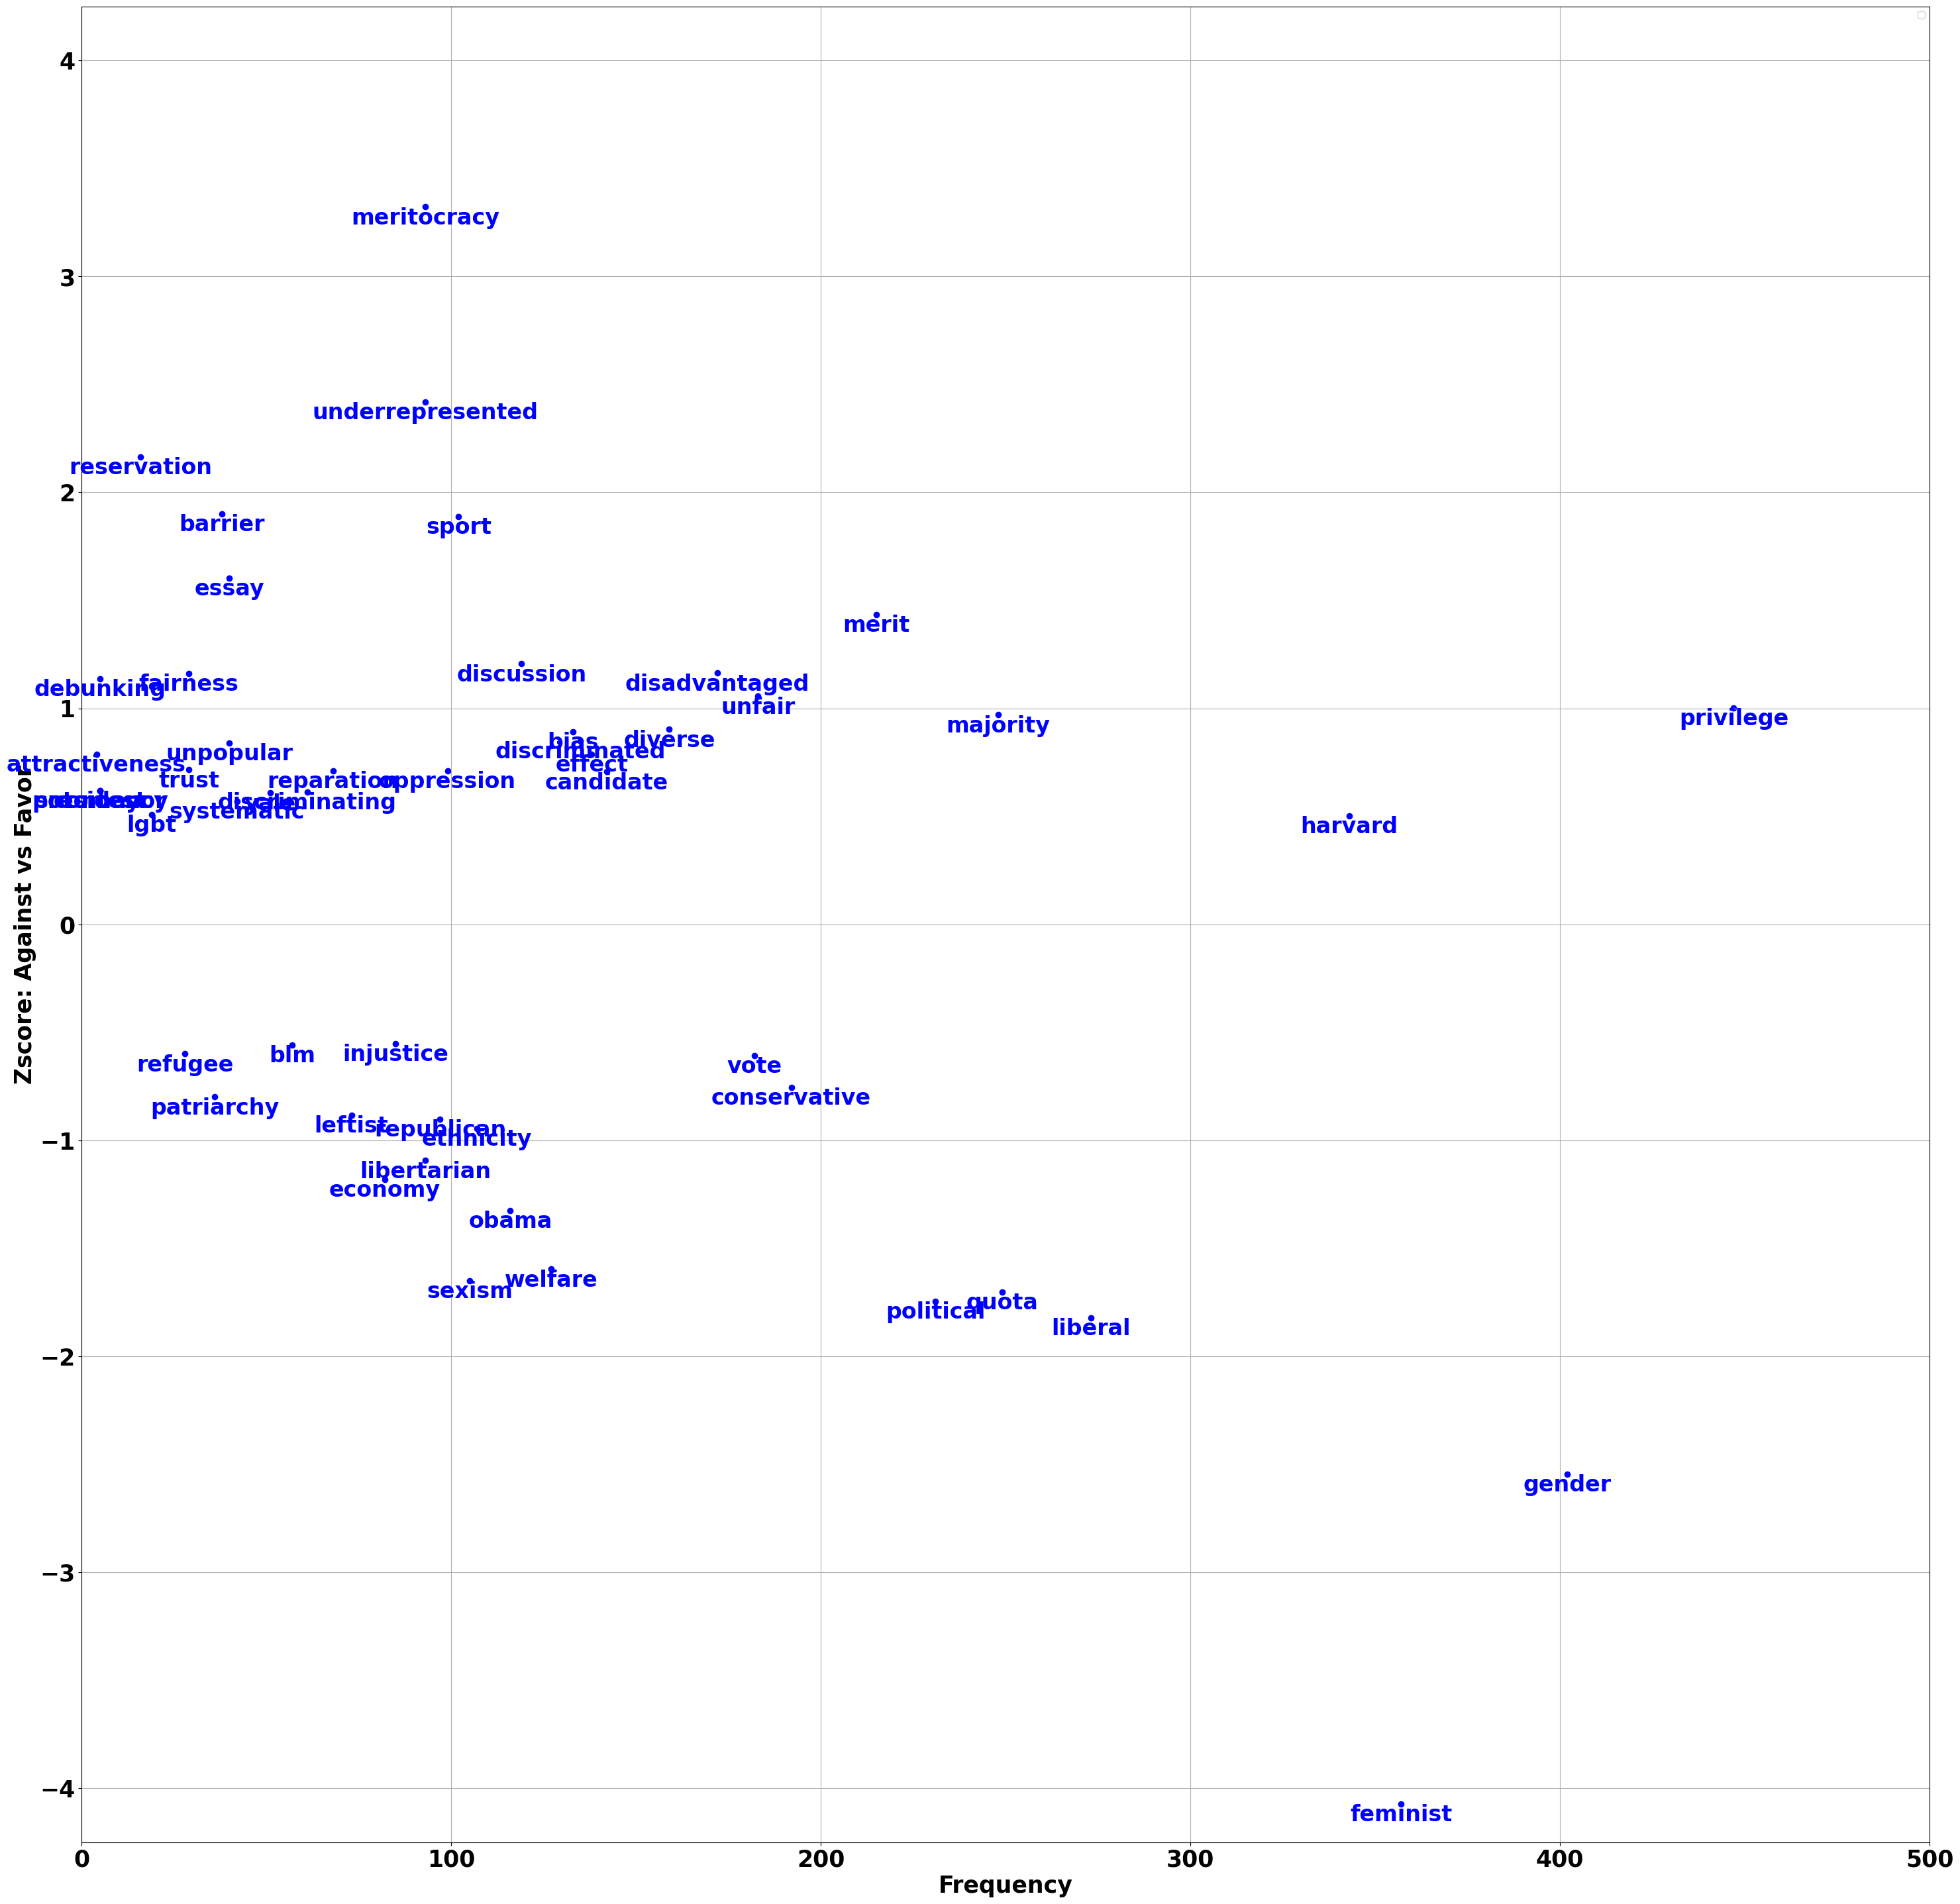

In [204]:
def zscore_stance():
    favor_da= Favor['text_process'].tolist()
    against_da= Against['text_process'].tolist()
    aspects= [i for i in aspects_all if sum(doc.split().count(i) for doc in favor_da) > 1 and sum(doc.split().count(i) for doc in against_da) > 1]
    aspects= [i for i in aspects if i!= 'aa']
    aspects= [i for i in aspects if i!= 'cmv']
    zscore_dict={}
    for i in aspects:
        try:
            zscore_dict[i]= z_score(i, favor_da, against_da)
        except:
            pass
    zscore_dict = {key: value for key, value in zscore_dict.items() if value<-0.5 or value>0.5}
    sorted_zscore = sorted(zscore_dict.items(), key=lambda x:x[1])
    freq_dict={}
    for i in aspects:
        freq_dict[i]= sum(doc.split().count(i) for doc in favor_da) + sum(doc.split().count(i) for doc in against_da)

    freq_dict_adj={}
    for kw in [i for i in list(freq_dict.keys()) if i in list(zscore_dict.keys())]:
        freq_dict_adj[kw]= freq_dict[kw]

    # Extract keys and values from dictionaries
    keys = list(zscore_dict.keys())
    values_dict1 = list(freq_dict_adj.values())
    values_dict2 = list(zscore_dict.values())

    # Create a 2-D plot
    plt.figure(figsize=(36, 36))
    plt.scatter(values_dict1, values_dict2, color='b')
    

    # Label the axes
    plt.xlabel('Frequency', fontsize=25, fontweight='bold', color='black')
    plt.ylabel('Zscore: Against vs Favor', fontsize=25, fontweight='bold', color='black')

    # Label each point with its corresponding key
    for i, key in enumerate(keys):
        plt.annotate(key, (values_dict1[i], values_dict2[i]), fontsize=24, fontweight='bold', ha='center', va='top', color = 'blue')
    plt.xlim(0, 500)
    plt.ylim(-4.25, 4.25)
    plt.xticks(fontsize=25, fontweight='bold', color='black')
    plt.yticks(fontsize=25, fontweight='bold', color='black')
    # Show legend and plot
    plt.legend()
    plt.grid(True)
    #plt.title('Aspects vs Frequency')
    plt.show()
zscore_stance()

# Error Analysis

In [82]:
# Get unique classes
data_merged= pd.read_csv('data_AA_combined_prompt.csv')

classes = np.unique(data_merged[['Final_Label', 'stance_finegrained_gpt4']])

# Initialize a dictionary to store results
results = {}

# Calculate TP, FP, TN, FN for each class
for cls in classes:
    TP = ((data_merged['Final_Label'] == cls) & (data_merged['stance_finegrained_gpt4'] == cls)).sum()
    FP = ((data_merged['Final_Label'] != cls) & (data_merged['stance_finegrained_gpt4'] == cls)).sum()
    TN = ((data_merged['Final_Label'] != cls) & (data_merged['stance_finegrained_gpt4'] != cls)).sum()
    FN = ((data_merged['Final_Label'] == cls) & (data_merged['stance_finegrained_gpt4'] != cls)).sum()

    # Calculate rates
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0  # False Negative Rate

    # Store results in the dictionary
    results[cls] = {
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'FPR': FPR,
        'FNR': FNR
    }

# Convert the results dictionary to a DataFrame for better readability
results_df = pd.DataFrame(results).transpose()

# Print the results
#results_df.to_csv('error_analysis.csv')
FP = data_merged[(data_merged['Final_Label'] != data_merged['stance_finegrained_gpt4']) & (data_merged['stance_finegrained_gpt4'].isin(data_merged['Final_Label'].unique()))]
FN = data_merged[(data_merged['Final_Label'] != data_merged['stance_finegrained_gpt4']) & (~data_merged['stance_finegrained_gpt4'].isin(data_merged['Final_Label'].unique()))]
fp_analysis = FP.groupby(['Final_Label', 'stance_finegrained_gpt4']).size().reset_index(name='Count')
fn_analysis = FN.groupby(['Final_Label', 'stance_finegrained_gpt4']).size().reset_index(name='Count')

fp_analysis = fp_analysis.sort_values(by='Count', ascending=False).reset_index().drop(columns=['index'])
fp_analysis.head(10)

,Final_Label,stance_finegrained_gpt4,Count
0,No Stance,Strong Against,24
1,Question Against,Strong Against,15
2,No Stance,Skeptical,13
3,Weak Against,Strong Against,12
4,Weak Against,No Stance,8
5,No Stance,Question,6
6,Question Against,Weak Against,6
7,Skeptical,Strong Against,5
8,Skeptical,No Stance,5
9,Skeptical,Question,5


In [85]:
classes = np.unique(data_merged[['Final_label', 'stance_general_gpt4']])

# Initialize a dictionary to store results
results = {}

# Calculate TP, FP, TN, FN for each class
for cls in classes:
    TP = ((data_merged['Final_label'] == cls) & (data_merged['stance_general_gpt4'] == cls)).sum()
    FP = ((data_merged['Final_label'] != cls) & (data_merged['stance_general_gpt4'] == cls)).sum()
    TN = ((data_merged['Final_label'] != cls) & (data_merged['stance_general_gpt4'] != cls)).sum()
    FN = ((data_merged['Final_label'] == cls) & (data_merged['stance_general_gpt4'] != cls)).sum()

    # Calculate rates
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0  # False Negative Rate

    # Store results in the dictionary
    results[cls] = {
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'FPR': FPR,
        'FNR': FNR
    }

# Convert the results dictionary to a DataFrame for better readability
results_df = pd.DataFrame(results).transpose()

# Print the results
#results_df.to_csv('error_analysis.csv')
FP = data_merged[(data_merged['Final_label'] != data_merged['stance_general_gpt4']) & (data_merged['stance_general_gpt4'].isin(data_merged['Final_label'].unique()))]
FN = data_merged[(data_merged['Final_label'] != data_merged['stance_general_gpt4']) & (~data_merged['stance_general_gpt4'].isin(data_merged['Final_label'].unique()))]
fp_analysis = FP.groupby(['Final_label', 'stance_general_gpt4']).size().reset_index(name='Count')
fn_analysis = FN.groupby(['Final_label', 'stance_general_gpt4']).size().reset_index(name='Count')

fp_analysis = fp_analysis.sort_values(by='Count', ascending=False).reset_index().drop(columns=['index'])
fp_analysis.head(10)

,Final_label,stance_general_gpt4,Count
0,Neutral,Against,49
1,Against,Neutral,20
2,Favor,Neutral,7
3,Favor,Against,6
4,Neutral,Favor,6
5,Against,Favor,1
